# Labraries and functions

## Load labraries

In [1]:
import os
import numpy as np
import pandas as pd
import time
import fatpack
import rainflow
from scipy.signal import butter, filtfilt, detrend
#import torch
#from torch.utils.data import Dataset, DataLoader
#import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard


from tensorflow.keras.layers import Add, BatchNormalization, Input, Conv1D, Activation, MaxPooling1D, Flatten, Dense, Dropout, MultiHeadAttention,Layer,LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.layers import ZeroPadding1D


from keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, Activation, Flatten
from keras import backend as K
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Activation, Dropout, concatenate, BatchNormalization
from keras.regularizers import l2



# filter the warnings
import warnings
warnings.filterwarnings("ignore")


import random
# Seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seed(42)

In [2]:
# use gpu for tf
physical_devices = tf.config.list_physical_devices('GPU')
# check if the GPU is used
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Define Functions

In [3]:
def calculate_receptive_field(kernels, strides, pools):
    """
    Calculate the receptive field for a series of convolutional and pooling layers.

    Parameters:
    - kernels (list of int): List of kernel sizes for each convolutional layer.
    - strides (list of int): List of stride values for each convolutional layer.
    - pools (list of int): List of pool sizes for each pooling layer (assumed to follow each conv layer).

    Returns:
    - int: The receptive field of the network.
    """
    receptive_field = 1
    jump = 1
    
    for kernel, stride, pool in zip(kernels, strides, pools):
        receptive_field += (kernel - 1) * jump
        jump *= stride
        receptive_field += (pool - 1) * jump
        jump *= pool
    
    return receptive_field

# Function to round values to the nearest interval of 0.5
def round_to_nearest_half(values):
    return np.round(values * 2) / 2


def custom_loss(y_true, y_pred):
    """
    Custom loss function that applies a different penalty if the prediction is less than the actual value.
    If the prediction is smaller, the loss is 2 times the usual mean squared error.
    Otherwise, the loss is the normal mean squared error.
    """
    # Calculate the squared difference
    squared_difference = tf.square(y_true - y_pred)
    
    # Check where predictions are smaller than true values
    under_prediction = tf.cast(y_pred < y_true, dtype=tf.float32)
    
    # Apply double weight to under-predictions
    weighted_squared_difference = squared_difference * (1 + under_prediction)
    
    # Return mean of weighted squared difference
    return tf.reduce_mean(weighted_squared_difference, axis=-1)


# Cyclical Learning Rate (CLR) Scheduler
class CyclicLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr, max_lr, step_size, mode='triangular'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.clr_iterations = 0
        self.trn_iterations = 0
        self.history = {}

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.mode == 'triangular':
            lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x))
        return lr

    def on_train_begin(self, logs=None):
        logs = logs or {}
        if self.clr_iterations == 0:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())




def weighted_mse_exponential(y_true, y_pred):
    # Define exponential weights - ensure this matches your output size
    # Convert the base and exponent range to float32 explicitly
    
    base_weight = 1.2  # Use float to ensure type compatibility

    exponent_range = K.cast(K.arange(1, 17), 'float32')  # Explicitly cast to float32
    weights = K.pow(base_weight, exponent_range)  # Now both base and exponent are float32
    weights = K.reshape(weights, (1, 16))  # Reshape to match y_pred shape
    # normalize the weights
    weights = weights / K.sum(weights)
    
    # Calculate MSE
    error = y_true - y_pred
    squared_error = K.square(error)
    weighted_squared_error = squared_error * weights  # Apply weights
    return K.mean(weighted_squared_error, axis=-1)


def weighted_mse_exponential_modified(y_true, y_pred):
    # Define exponential weights for the first 18
    base_weight = 1.6  # Use float to ensure type compatibility
    
    # First 18 weights increasing
    exponent_range_increasing = K.cast(K.arange(1, 13), 'float32')  # Exponents for the increasing part
    increasing_weights = K.pow(base_weight, exponent_range_increasing)  # Increasing weights
    
    # Last 6 weights decreasing - Option 1: Direct computation of decreasing weights
    exponent_range_decreasing = K.cast(K.arange(1, 13), 'float32')  # Exponents for the decreasing part, could be adjusted
    decreasing_weights = K.pow(base_weight, -exponent_range_decreasing)  # Make these weights decrease
    decreasing_weights = decreasing_weights * K.pow(base_weight, 12)  # Adjust to make sure they start from where increasing part left off
    
    # Concatenate the increasing and decreasing weights
    weights = K.concatenate([increasing_weights, decreasing_weights], axis=0)
    # Normalize the weights
    weights = weights / K.sum(weights)
    weights = K.reshape(weights, (1, 24))  # Reshape to match y_pred shape

    # Calculate MSE
    error = y_true - y_pred
    squared_error = K.square(error)
    weighted_squared_error = squared_error * weights  # Apply weights
    return K.mean(weighted_squared_error, axis=-1)




def weighted_mse_exponential_normal_distribution(y_true, y_pred):
    # Parameters for the normal distribution
    mu = 10.0  # Mean of the distribution, centered at 12 for a 24-length sequence
    sigma = 3.0  # Standard deviation of the distribution
    
    # Generate indices for the weights
    x_values = tf.range(1, 21, dtype=tf.float32)
    
    # Calculate the normal distribution weights using TensorFlow operations
    weights = tf.exp(-((x_values - mu) ** 2) / (2 * sigma ** 2))
    
    # Normalize weights to ensure they sum to 1 (optional based on your requirement)
    weights /= tf.reduce_sum(weights)
    
    # Reshape weights to match y_pred shape
    weights = tf.reshape(weights, (1, 21))
    

    # Calculate weighted MSE using TensorFlow operations
    error = y_true - y_pred
    squared_error = tf.square(error)
    weighted_squared_error = squared_error * weights  # Apply weights
    return tf.reduce_mean(weighted_squared_error, axis=-1)


def weighted_mse_log_normal_distribution(y_true, y_pred):
    # Parameters for the log-normal distribution
    mu = 2.7  # Adjusted for the scale of indices, typically log of the mean of x-values
    sigma = 0.6  # Adjusted variance

    # Generate indices for the weights
    x_values = tf.range(1, 21, dtype=tf.float32)
    
    # Calculate the log-normal distribution weights using TensorFlow operations
    # Adjusting x_values to be in the domain > 0 and applying log-normal PDF formula
    weights = (1 / (x_values * sigma * tf.sqrt(2 * np.pi))) * tf.exp(-((tf.math.log(x_values) - mu) ** 2) / (2 * sigma ** 2))
    
    # Normalize weights to ensure they sum to 1 (optional based on your requirement)
    weights /= tf.reduce_sum(weights)
    
    # Reshape weights to match y_pred shape
    weights = tf.reshape(weights, (1, 21))
    
    # Calculate weighted MSE using TensorFlow operations
    error = y_true - y_pred
    squared_error = tf.square(error)
    weighted_squared_error = squared_error * weights  # Apply weights
    return tf.reduce_mean(weighted_squared_error, axis=-1)




def create_dataset(X, y, window_size,pred_num = 1):
    """"
    This function creates the dataset with the window size for lstm
    The input data might be the train_x or test_x or test_y or train_y
    The window size is the number of data points in each

    x: the input data
    y: the output data
    window_size: the number of data points in each window
    pred_num: the number of data points

    """

    Xs, ys = [], []
    for i in range(len(X) - window_size):
        v = X.iloc[i:(i + window_size)]
        Xs.append(v)
        ys.append(y.iloc[i +window_size +1-pred_num:i +window_size + 1])
    return np.array(Xs), np.array(ys) 




def plot_fft(signal, title, plot = 0, eli = 15):
    """
    This function plots the FFT of a signal.

    signal: the signal to plot the FFT of  
    title: the title of the plot
    plot: the number of points to plot
    eli: the number of points to eliminate from frequency domain
    """     
                    
    # Compute the FFT
    fft_vals = np.fft.fft(signal)
    fft_vals = np.abs(fft_vals)/len(signal)   # normalized values
    fft_vals[:eli] = 0             # eliminate the influence of first component


    # Compute the frequencies associated with the FFT values
    # The frequency is set as 150Hz
    fft_freq = np.fft.fftfreq(len(signal),1/200)

    # Plot the FFT values vs frequencies
    plt.figure(figsize=(10, 5))
    if plot != 0:
      plt.plot(np.abs(fft_freq)[:plot], fft_vals[:plot])
    else:
      plt.plot(np.abs(fft_freq), fft_vals)
    plt.title(f'FFT of {title}')
    plt.xlabel('Frequency')
    plt.ylabel('FFT Value')
    plt.grid(True)
    plt.show()



def butter_lowpass(signal, cutoff, fs, order=5, btype='low'):
    """
    Attenuate the signal with a low-pass Butterworth

    Parameters:
    - signal: The input signal (1D numpy array).
    - cutoff: Cut-off frequency (Hz)
    - btpe: The type of filter. 'low' for low-pass filter.
    - order: The order of the filter.
    - fs: The sampling frequency of the signal (Hz).

    Returns:
    - filtered_signal: The filtered signal (1D numpy array).
    """
    # Nyquist frequency
    nyquist = 0.5 * fs
    # Normalize the frequency
    normal_cutoff = cutoff / nyquist
    
    # Design the Butterworth filter
    b, a = butter(order, normal_cutoff, btype=btype)
    # Apply the filter
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal




def zero_out_frequency_range_fft(signal, lowcut, highcut, fs = 200):
    """
    Zero out a specific frequency range in a signal using FFT.

    Parameters:
    - signal: The input signal (1D numpy array).
    - lowcut: The lower frequency bound to zero out (Hz).
    - highcut: The upper frequency bound to zero out (Hz).
    - fs: The sampling frequency of the signal (Hz).

    Returns:
    - signal_filtered: The signal with the specified frequency range zeroed out.
    """
    # Perform FFT
    signal_fft = np.fft.fft(signal)
    # Get the frequency bins
    freq = np.fft.fftfreq(len(signal), 1/fs)
    
    # Zero out the desired frequency range
    # Use np.logical_and to find the indices where the frequency range falls
    mask = np.logical_or(freq < highcut, freq > lowcut)
    mask = np.logical_or(mask, freq > -lowcut)
    mask = np.logical_or(mask, freq < -highcut)
    signal_fft[mask] = 0

    # Perform inverse FFT
    signal_filtered = np.fft.ifft(signal_fft)

    # Since the imaginary part is due to numerical error, we take only the real part
    return np.real(signal_filtered)


def find_time_delay(signal1, signal1_name, signal2, signal2_name, fs, sensor_data = True, save_plot=False):
    """
    Find the time delay between two signals based on cross-correlation.
    
    :param signal1: The first signal (array-like).
    :param signal2: The second signal (array-like).
    :param fs: Sampling frequency of the signals.
    :return: Time delay in seconds.
    """
    # Compute cross-correlation
    correlation = np.correlate(signal1, signal2, mode='full')
    
    # Find the lag corresponding to the maximum correlation
    lag_idx = np.argmax(correlation) - (len(signal2) - 1)
    
    # Convert lag to time in seconds
    time_delay = lag_idx / fs
    
    # Visualize the cross-correlation process
    lags = np.arange(-len(signal2) + 1, len(signal1))
    time_lags = lags / fs
    plt.figure(figsize=(12, 6))
    plt.plot(time_lags, correlation)
    if sensor_data:
        title = 'Cross-Correlation of signal '+signal1_name+' and '+signal2_name +' (sensor)'
    else:
        title = 'Cross-Correlation of signal '+signal1_name+' and '+signal2_name +' (FEM data)' 
    plt.title(title)
    plt.xlabel('Time Lag (s)')
    plt.ylabel('Cross-Correlation Amplitude')
    plt.axvline(time_delay, color='r', linestyle='--', label=f'Time Delay: {time_delay}s')
    plt.legend()
    plt.grid(True)
    if save_plot:
        plt.savefig(title+'.svg', dpi=1000)
    
    plt.show()
    
    return time_delay


# Load data & preparation

In [4]:
folder_path = "../Data/Vänersborg Bridge"
# Get a list of all CSV files
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
print(f"{len(file_list)} CSV files found.")

72 CSV files found.


In [5]:
# read all csv file in the folder Vänersborg Bridge 
# and save them in a dictionary called data_dict
data_dict = {}
for i in range(len(file_list)):
    data_dict[i] = pd.read_csv('../Data/Vänersborg Bridge/data_dict_' + str(i) + '.csv')
    # delete the first 1000 data points and the last 1000 data points
    data_dict[i] = data_dict[i]#.iloc[1500:-1500]
    # Reset the index
    data_dict[i] = data_dict[i].reset_index(drop=True)

## Data visualization

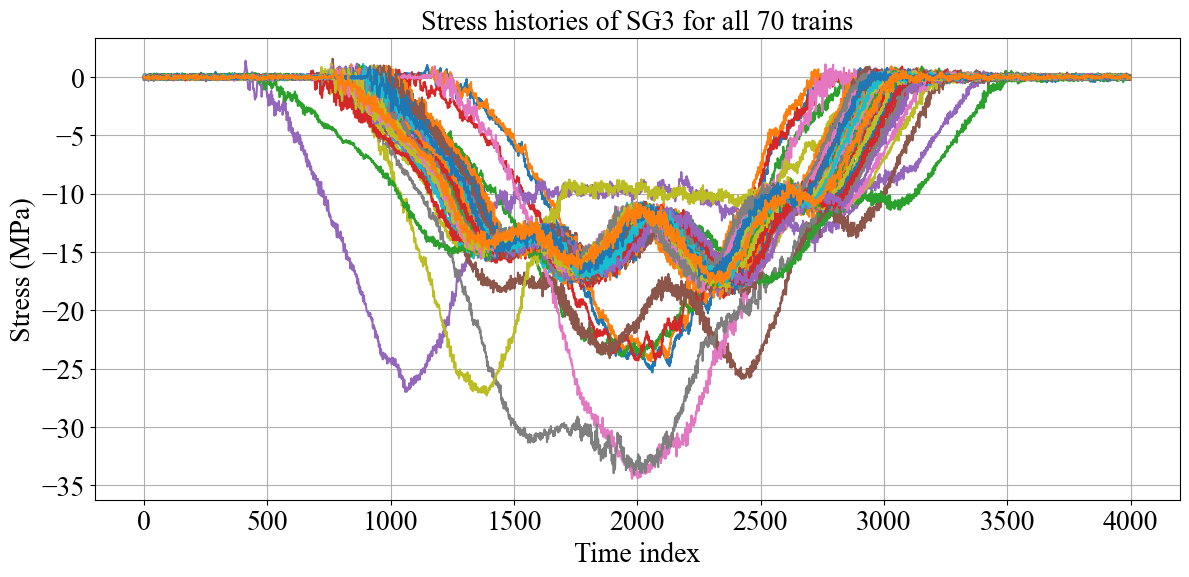

In [6]:
# plot all sg3 signal in one figure
plt.figure(figsize=(14, 6))
for i in range(len(file_list)):
    plt.plot(data_dict[i]['SG7'], label=f'Index {file_list[i]}')
#plt.legend()
plt.title("Stress histories of " + data_dict[0].columns[4] + " for all 70 trains", fontsize=20, fontname = 'Times New Roman')
plt.xlabel("Time index", fontsize=20, fontname = 'Times New Roman')
plt.ylabel("Stress (MPa)", fontsize=20, fontname = 'Times New Roman')
# set the x-axis and y-axis label font size and font type to new roman

plt.xticks(fontsize=20, fontname = 'Times New Roman')
plt.yticks(fontsize=20, fontname = 'Times New Roman')

plt.grid(True)
plt.show()

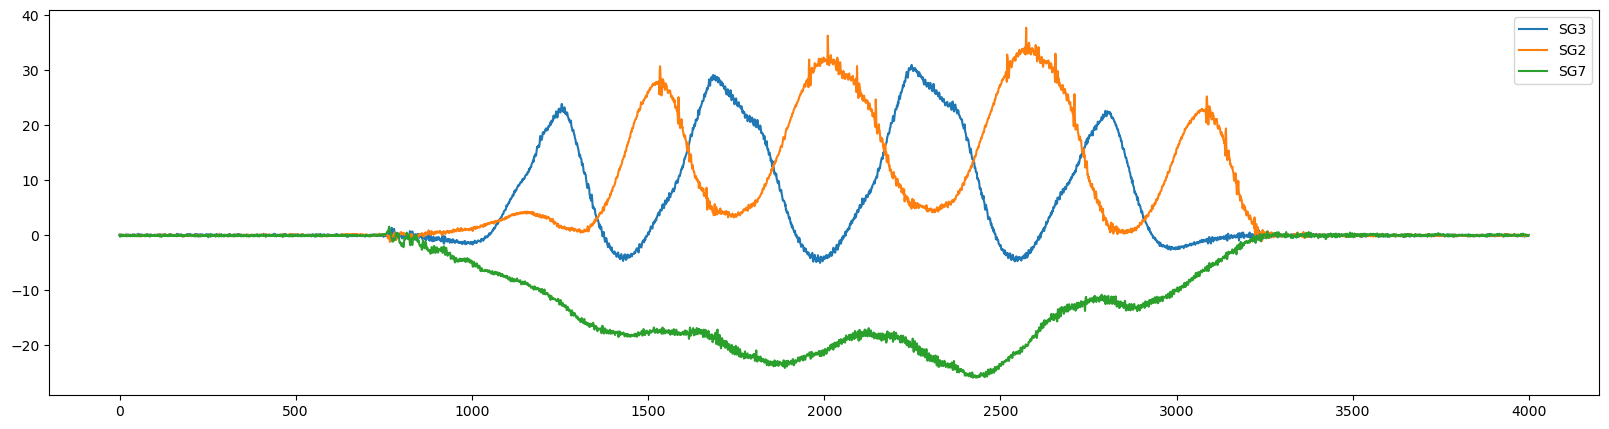

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(data_dict[5]['SG3'],  label = 'SG3')
plt.plot(data_dict[5]['SG2'],  label = 'SG2')
plt.plot(data_dict[5]['SG7'],  label = 'SG7')
# save the plot wiht svg
#plt.savefig('SG3_SG2_SG7.svg', dpi=1000)
plt.legend()
plt.show()



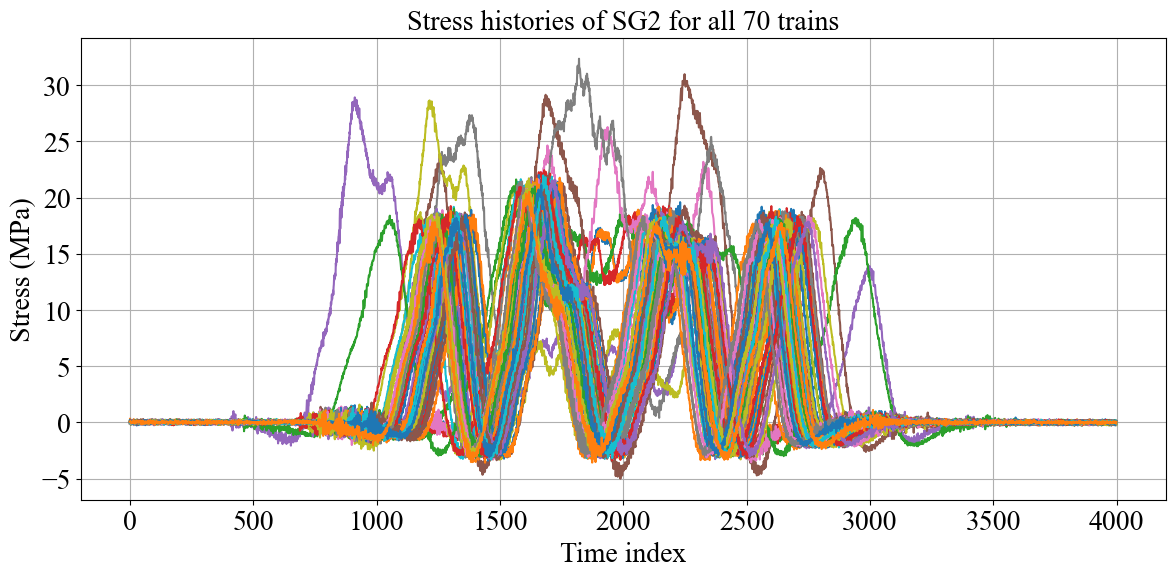

In [8]:
# plot all sg3 signal in one figure
plt.figure(figsize=(14, 6))
for i in range(len(file_list)):
    plt.plot(data_dict[i]['SG3'], label=f'Index {file_list[i]}')
#plt.legend()
plt.title("Stress histories of " + data_dict[0].columns[3] + " for all 70 trains", fontsize=20, fontname = 'Times New Roman')
plt.xlabel("Time index", fontsize=20, fontname = 'Times New Roman')
plt.ylabel("Stress (MPa)", fontsize=20, fontname = 'Times New Roman')
# set the x-axis and y-axis label font size and font type to new roman

plt.xticks(fontsize=20, fontname = 'Times New Roman')
plt.yticks(fontsize=20, fontname = 'Times New Roman')

plt.grid(True)
plt.show()


## Data augmentation


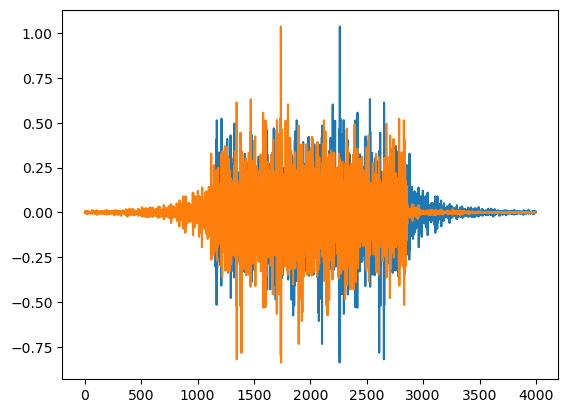

In [9]:
for i in range(0, 1):
    plt.plot(data_dict[i]['A1'], label=f'Index {file_list[i]}')
    plt.plot(data_dict[i]['A1'].values[::-1], label=f'Index {file_list[i]}')



In [10]:
len(data_dict.keys())

72

In [11]:
data_dict[len(data_dict.keys())] = 0
data_dict[len(data_dict.keys())] = 0
data_dict[len(data_dict.keys())] = 0
data_dict[len(data_dict.keys())] = 0
data_dict[len(data_dict.keys())] = 0
data_dict[len(data_dict.keys())] = 0
data_dict[len(data_dict.keys())] = 0
data_dict[len(data_dict.keys())] = 0
data_dict[len(data_dict.keys())] = 0

In [12]:
data_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

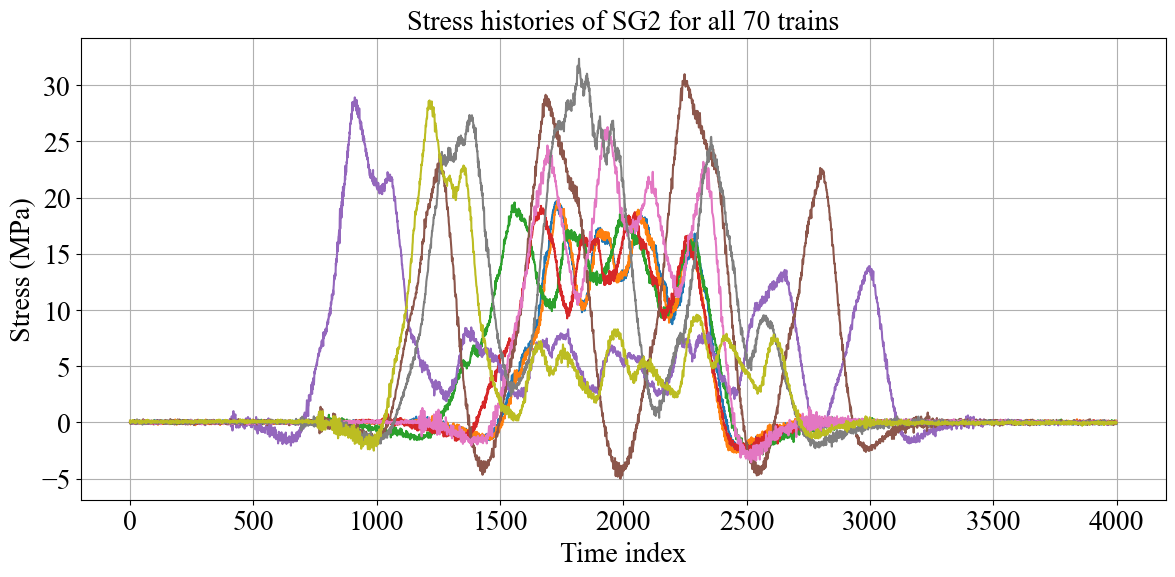

In [13]:
# plot all sg3 signal in one figure
plt.figure(figsize=(14, 6))
for i in range(9):
    plt.plot(data_dict[i]['SG3'], label=f'Index {file_list[i]}')
#plt.legend()
plt.title("Stress histories of " + data_dict[0].columns[3] + " for all 70 trains", fontsize=20, fontname = 'Times New Roman')
plt.xlabel("Time index", fontsize=20, fontname = 'Times New Roman')
plt.ylabel("Stress (MPa)", fontsize=20, fontname = 'Times New Roman')
# set the x-axis and y-axis label font size and font type to new roman

plt.xticks(fontsize=20, fontname = 'Times New Roman')
plt.yticks(fontsize=20, fontname = 'Times New Roman')

plt.grid(True)
plt.show()

In [14]:


# for the first nine data in the data_dict, reverse the data_dict[i]['A1'] and data_dict[i]['A3'] and then save the reversed data into the data_dict with new key
import copy

for i in range(9):
    A1 = data_dict[i]['A1'].values[::-1]# Make a copy of the reversed array
    A2 = data_dict[i]['A2'].values[::-1]# Make a copy of the reversed array
    A3 = data_dict[i]['A3'].values[::-1] # Make a copy of the reversed array
    SG2 = data_dict[i]['SG2'].copy()
    SG3 = data_dict[i]['SG3'].copy()
    SG7 = data_dict[i]['SG7'].copy()
    SG2_Range = data_dict[i]['SG2-Range'].copy()
    SG2_Cycles = data_dict[i]['SG2-Cycles'].copy()
    SG3_Range = data_dict[i]['SG3-Range'].copy()
    SG3_Cycles = data_dict[i]['SG3-Cycles'].copy()
    SG7_Range = data_dict[i]['SG7-Range'].copy()
    SG7_Cycles = data_dict[i]['SG7-Cycles'].copy()
    
# Append the reversed array to the data_dict with new key
    data_dict[ i + 72 ] = pd.DataFrame({'A1': A1, 'A2': A2, 'A3': A3, 'SG2': SG2, 'SG3': SG3, 'SG7': SG7, 'SG2-Range': SG2_Range, 'SG2-Cycles': SG2_Cycles, 'SG3-Range': SG3_Range, 'SG3-Cycles': SG3_Cycles, 'SG7-Range': SG7_Range, 'SG7-Cycles': SG7_Cycles})




In [15]:
data_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

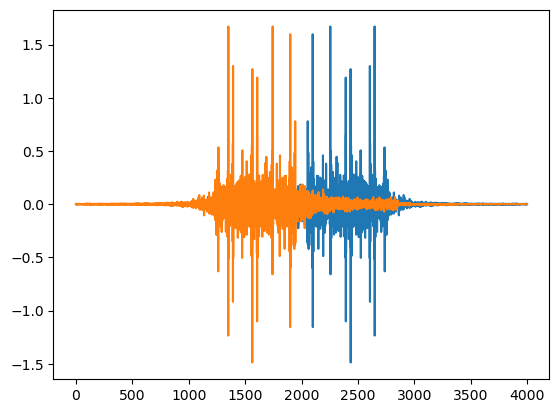

In [16]:
plt.plot(data_dict[0]['A3'], label='train 1')
plt.plot(data_dict[72]['A3'], label='train 73')


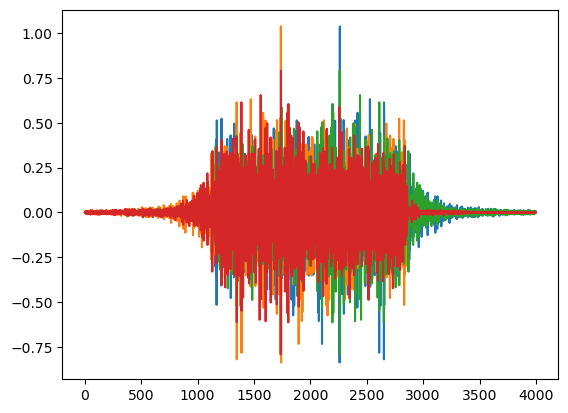

In [17]:
plt.plot(data_dict[0]['A1'], label='train 1')
plt.plot(data_dict[72]['A1'], label='train 73')

plt.plot(data_dict[0]['A2'], label='train 1')
plt.plot(data_dict[72]['A2'], label='train 73')

In [18]:
len(data_dict.keys())

81

In [19]:
split_ratio = 0.9  # 90% for training, 20% for test
# randomly take 80 % of number from all the data
#set the random seed

# 12345
random.seed(123456)
train_num = random.sample(range(len(data_dict.keys())), int(len(data_dict.keys())*split_ratio))
# merge the train number and shuffle it
random.shuffle(train_num)

# the rest of the number in low_speed_num and high_speed_num are the test set
test_num = [i for i in range(len(data_dict.keys())) if i not in train_num]
# merge the test number and shffle it
random.shuffle(test_num)

# Create two dictionaries for training and testing sets based on the split
data_training = {train: data_dict[train] for train in train_num}
data_testing = {train: data_dict[train] for train in test_num}



In [20]:
data_testing.keys(),data_training.keys(),len(data_testing),len(data_training)

(dict_keys([50, 52, 64, 31, 74, 51, 40, 61, 44]),
 dict_keys([5, 79, 46, 14, 62, 37, 24, 70, 30, 71, 56, 77, 11, 15, 36, 72, 54, 25, 18, 3, 35, 10, 33, 49, 39, 6, 29, 78, 43, 8, 41, 63, 58, 47, 80, 68, 75, 9, 73, 12, 32, 38, 65, 23, 67, 1, 19, 60, 76, 66, 55, 20, 45, 4, 69, 0, 34, 57, 28, 21, 22, 42, 7, 53, 27, 16, 17, 13, 2, 26, 48, 59]),
 9,
 72)

In [21]:
data_testing[50]

,A1,A2,A3,SG2,SG3,SG7,SG2-Range,SG2-Cycles,SG3-Range,SG3-Cycles,SG7-Range,SG7-Cycles
0,-0.000097,-0.000046,-0.000338,-0.005371,-0.022669,-0.108365,2.0,996.5,2.0,1023.0,2.0,972.0
1,-0.000116,-0.000128,-0.000208,-0.064171,-0.079369,-0.083165,4.0,14.0,4.0,9.5,4.0,6.0
2,-0.000034,-0.000057,-0.000242,0.112229,0.065531,0.042835,6.0,5.0,6.0,0.0,6.0,1.0
3,-0.000013,0.000292,0.000090,0.051329,0.149531,0.059635,8.0,0.0,8.0,0.0,8.0,0.0
4,0.000022,0.000143,0.000174,-0.072571,0.029831,-0.064265,10.0,0.0,10.0,0.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.001721,-0.007052,-0.000330,0.061829,0.094931,-0.011765,NaN,NaN,NaN,NaN,NaN,NaN
3996,0.009605,-0.003711,0.000718,-0.013771,0.025631,-0.135665,NaN,NaN,NaN,NaN,NaN,NaN
3997,0.003095,0.001138,0.000277,-0.097771,-0.054169,-0.049565,NaN,NaN,NaN,NaN,NaN,NaN
3998,0.003596,0.012029,0.001058,0.074429,0.126431,0.112135,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# import minmaxscaler to normalize the data
from sklearn.preprocessing import MinMaxScaler

data_training_X = {}
data_training_Y = {}
for key in data_training:

    data_training_X[key] = data_training[key][['A3','A1','A2']]

    data_training_Y[key] = data_training[key]['SG3-Cycles'].dropna()



# data_testing_X is the first column of each dataframe in the data_testing
data_testing_X = {}
data_testing_Y = {}
for key in data_testing:

    data_testing_X[key] = data_testing[key][['A3','A1','A2']]

    data_testing_Y[key] = data_testing[key]['SG3-Cycles'].dropna()

    

In [23]:
# delete the frist row of the data_training_Y and data_testing_Y
drop_samll = True
if drop_samll:
    for key in data_training_Y:
        data_training_Y[key] = data_training_Y[key].iloc[1:]
    for key in data_testing_Y:
        data_testing_Y[key] = data_testing_Y[key].iloc[1:]

# put all arrays in the data_training_X in one tensor with shape of (number of data, 4500, 1) and igore the key of the dictionary
data_training_X = np.array([data_training_X[key] for key in data_training_X])
data_training_Y = np.array([data_training_Y[key] for key in data_training_Y])

# put all arrays in the data_testing_X in one tensor with shape of (number of data, 4500, 1) and igore the key of the dictionary
data_testing_X = np.array([data_testing_X[key] for key in data_testing_X])
data_testing_Y = np.array([data_testing_Y[key] for key in data_testing_Y])


data_testing_X.shape,data_testing_Y.shape,data_training_X.shape,data_training_Y.shape

((9, 4000, 3), (9, 24), (72, 4000, 3), (72, 24))

In [24]:
data_training_Y[0]

array([2.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0.5,
       0.5, 0. , 0.5, 1. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. ])

In [25]:
# Training parameters
batch_size = 64
epochs = 900
BatchNorm = True 
normal = True 
regularization_rate = 6.5e-1
# Initial learning rate
initial_learning_rate = 0.001
learning_rate_scheduler = False

# Models 

## CNN without attention

In [37]:
from tensorflow.keras import initializers


# Set a seed for weight initialization
initializer = initializers.GlorotUniform(seed=42)
np.random.seed(42)
tf.random.set_seed(42)


input_shape = data_training_X.shape[1:]

# 实例化一个Sequential
CNN_model = Sequential()

#Frist Conv1D layer
CNN_model.add(Conv1D(filters=128, kernel_size=6, strides=2, padding='same', kernel_initializer=initializer,kernel_regularizer=l2(1e-4), input_shape=input_shape))
#model.add(BatchNormalization())
CNN_model.add(Activation('relu'))
CNN_model.add(MaxPooling1D(pool_size=2))

#Second Conv1D layer
CNN_model.add(Conv1D(32,kernel_size=3, strides=1, padding='same', kernel_initializer=initializer,kernel_regularizer=l2(1e-4), input_shape=input_shape))
#model.add(BatchNormalization())
CNN_model.add(Activation('relu'))
CNN_model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))

#LSTM层
#model.add(LSTM(64, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', return_sequences=True))

# Flatten layer
CNN_model.add(Flatten())
CNN_model.add(Dropout(0.25))

# Fully connected layer
CNN_model.add(Dense(32,kernel_initializer=initializer))
CNN_model.add(Activation("relu"))

# 增加输出层，共num_classes个单元, and all positive values
CNN_model.add(Dense(units=24, activation='relu'))


# Compile the model
CNN_model.compile(optimizer='Adam', loss=custom_loss, metrics=['mean_squared_error'])


# Compile the model with the custom loss
#model.compile(optimizer='Adam', loss=weighted_mse_exponential, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_exponential_modified, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_exponential_normal_distribution, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_log_normal_distribution, metrics=['mean_squared_error'])


CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 2000, 128)         2432      
                                                                 
 activation_6 (Activation)   (None, 2000, 128)         0         
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1000, 128)        0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 1000, 32)          12320     
                                                                 
 activation_7 (Activation)   (None, 1000, 32)          0         
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 500, 32)          0         
 1D)                                                  

In [38]:
# training 
history = CNN_model.fit(x=data_training_X, y=data_training_Y, batch_size=batch_size, epochs=900,
          verbose=1, validation_split=0.2, shuffle=False)
          #callbacks=[tb_cb])

Epoch 1/900
1/1 [==============================] - 1s 693ms/step - loss: 2.3210 - mean_squared_error: 1.1580 - val_loss: 1.0084 - val_mean_squared_error: 0.5231
Epoch 2/900
1/1 [==============================] - 0s 33ms/step - loss: 1.8734 - mean_squared_error: 0.9558 - val_loss: 0.9511 - val_mean_squared_error: 0.6005
Epoch 3/900
1/1 [==============================] - 0s 36ms/step - loss: 1.5734 - mean_squared_error: 0.9125 - val_loss: 1.2210 - val_mean_squared_error: 0.9333
Epoch 4/900
1/1 [==============================] - 0s 36ms/step - loss: 1.5928 - mean_squared_error: 1.1118 - val_loss: 1.0886 - val_mean_squared_error: 0.8031
Epoch 5/900
1/1 [==============================] - 0s 36ms/step - loss: 1.4478 - mean_squared_error: 0.9740 - val_loss: 0.8849 - val_mean_squared_error: 0.5880
Epoch 6/900
1/1 [==============================] - 0s 34ms/step - loss: 1.2971 - mean_squared_error: 0.7904 - val_loss: 0.7969 - val_mean_squared_error: 0.4881
Epoch 7/900
1/1 [======================

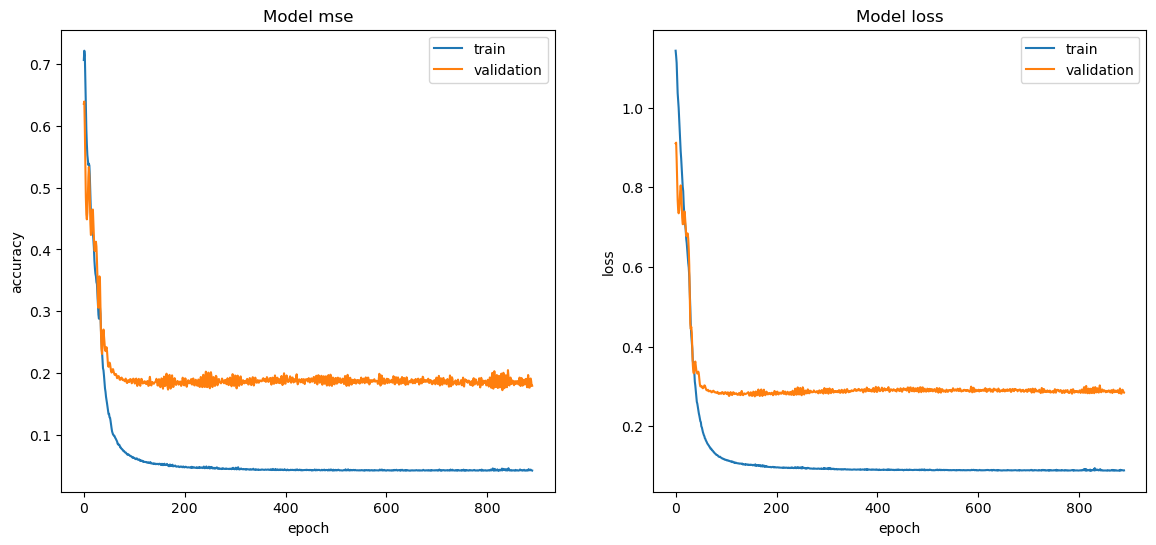

In [39]:
#plot the mse of the training and validation on the left(2,1) and the loss of the training and validation on the right(2,2)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_squared_error'][10:])
plt.plot(history.history['val_mean_squared_error'][10:])
plt.title('Model mse')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'],loc = 'upper right')
plt.show()


In [40]:
#set a timer to record the time of the prediction]
import time
start = time.time()
# predict the data_testing_X
y_pred = CNN_model.predict(data_testing_X)

end = time.time()
print("Time taken to predict the data_testing_X is ", end - start)
# Rounding the predictions
rounded_predictions = round_to_nearest_half(y_pred)


Time taken to predict the data_testing_X is  0.2968170642852783


In [41]:
# calculate the mse of prediction

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# calculate the mse of the prediction
mse = mean_squared_error(data_testing_Y, y_pred)

mse

0.460014146179829

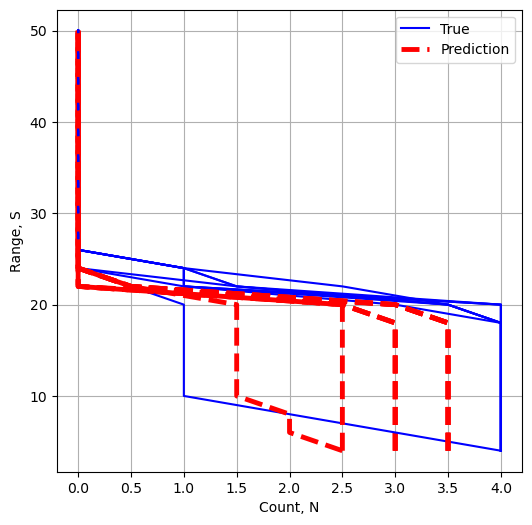

In [42]:
S = list(range(4,52,2))

# Plot all predictions on a same plot
figure = plt.figure(figsize=(6, 6))
for i in range(len(rounded_predictions)):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    #plt.semilogx(Ncum, S, color = 'blue')
    plt.plot(Ncum, S, color = 'blue',linewidth=1.5, label='True')
    #plt.semilogx(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5)
    plt.plot(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5, label='Prediction')
    #plt.title('train number = '+str(test_num[i]))
    # plot the one sigma error bar
    #plt.fill_betweenx(S, pre_Ncum - one_sigma, pre_Ncum + one_sigma, color='red', alpha=0.05)
    plt.xlabel('Count, N')
    plt.ylabel('Range, S')
    #plt.legend()
    plt.grid(True)
    if i == 0:
        plt.legend()

# add a test to the plot to show the color of the line


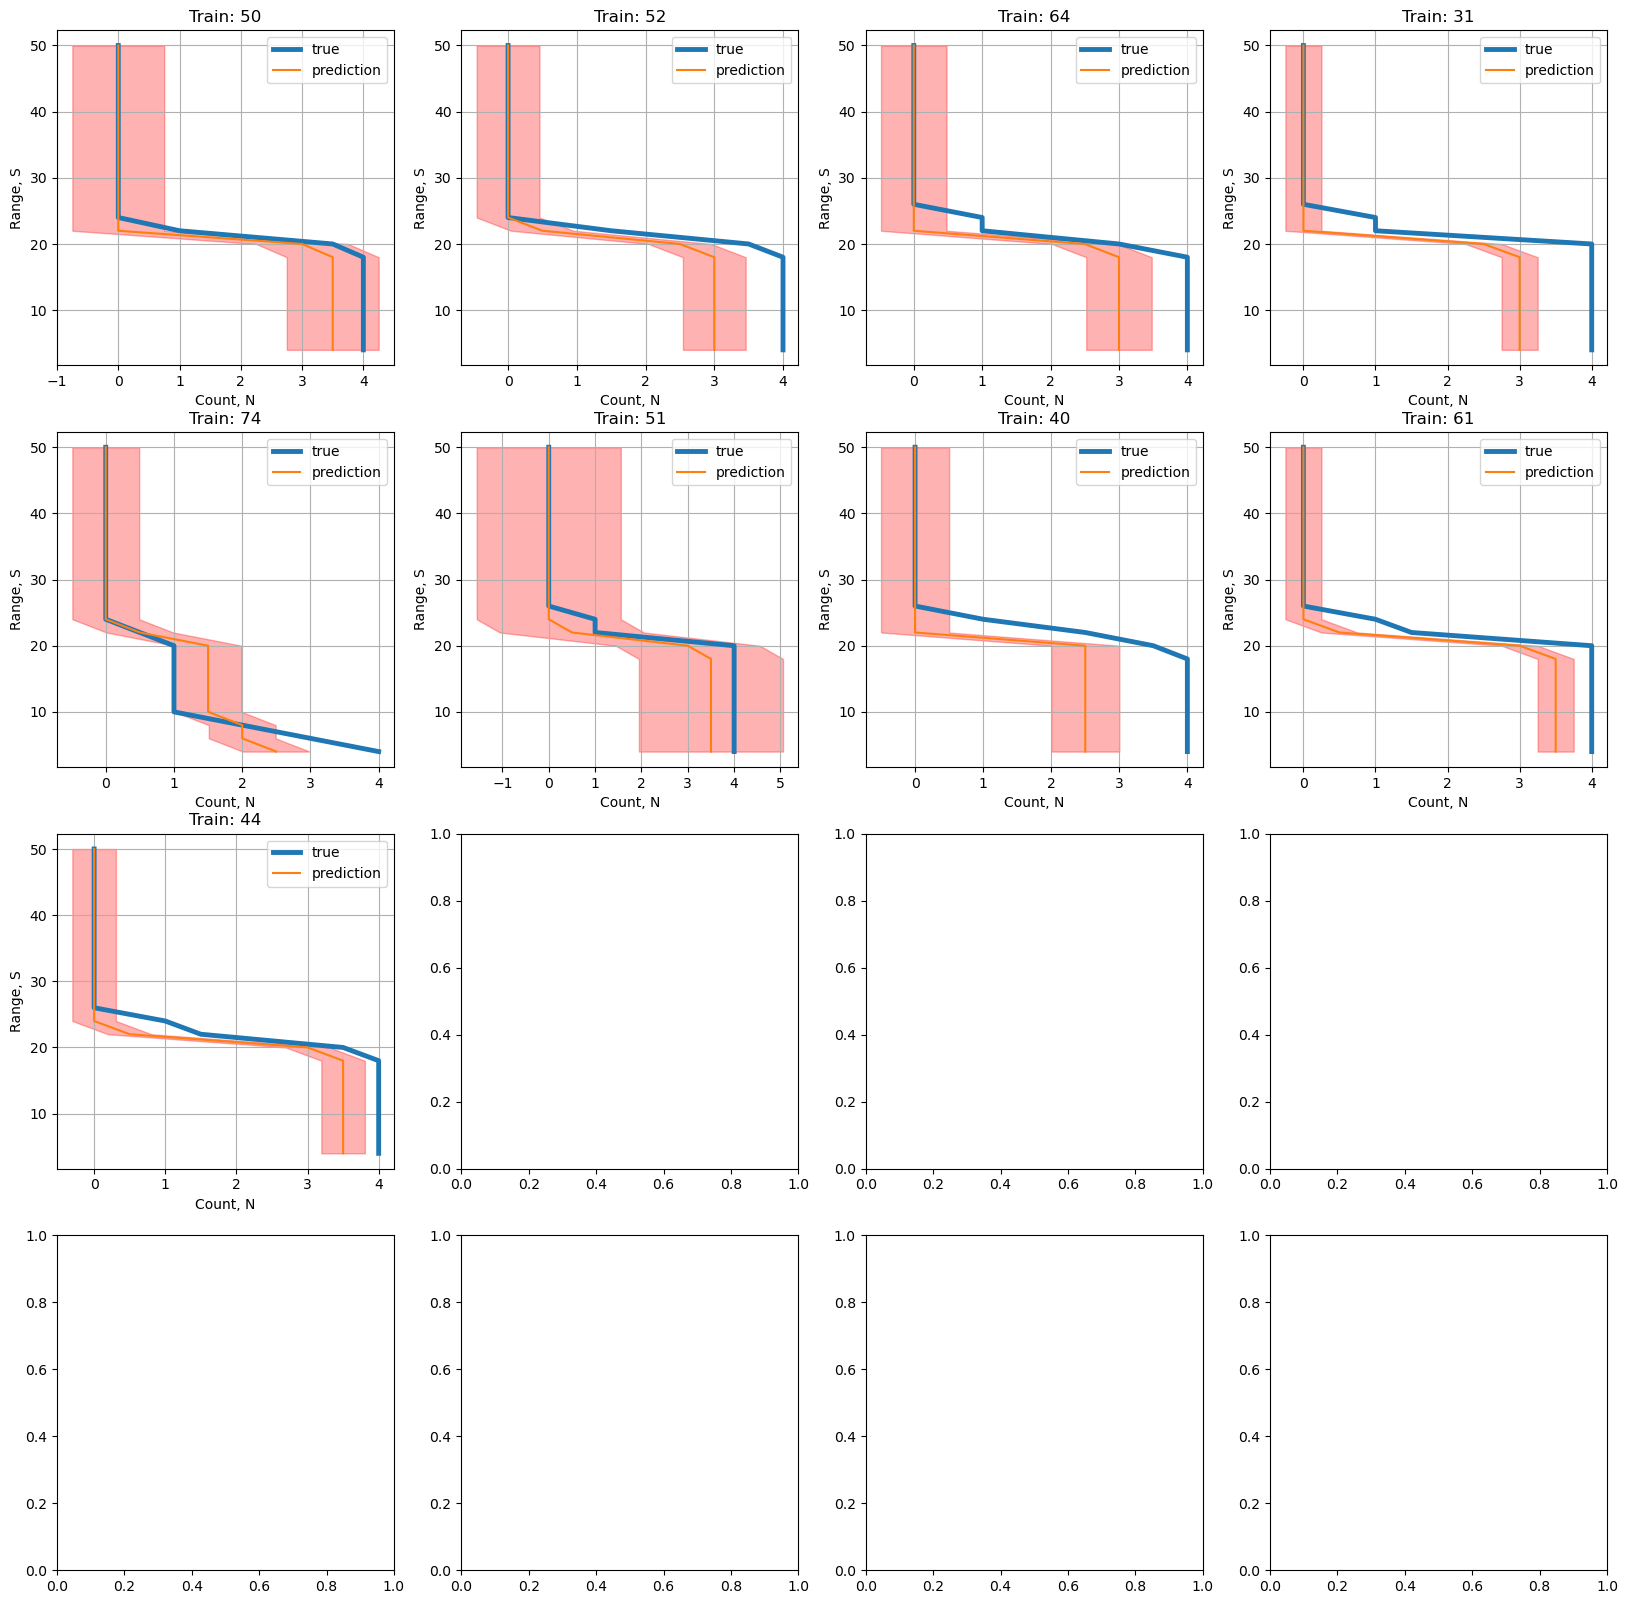

In [43]:


# plot all predictions on a plot with the same color
S = list(range(4,52,2))
figure, axes = plt.subplots(4, 4, figsize=(20, 20))

for i in range(len(rounded_predictions)):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    # calculate the one sigma of the prediction
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    ax = axes[i//4, i%4]
    ax.plot(Ncum, S, label='true',linewidth=3.5)
    # plot the two sigma of the prediction
    ax.fill_betweenx(S, pre_Ncum-1*one_sigma, pre_Ncum+1*one_sigma, color='r', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma, pre_Ncum+1*one_sigma-2*one_sigma, color='y', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum+1*one_sigma, pre_Ncum+2*one_sigma, color='y', alpha=0.3)

    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma-3*one_sigma, pre_Ncum+2*one_sigma+3*one_sigma, color='b', alpha=0.1)

    ax.plot(pre_Ncum, S, label='prediction')
    ax.set_title('Train: '+str(test_num[i]))
    ax.set_xlabel('Count, N')
    ax.set_ylabel('Range, S')
    ax.legend()
    ax.grid(True)

## CNN-Attention

In [44]:

kernels = [9, 5, 3]  # kernel sizes for each conv layer
strides = [3, 3, 2]  # stride values for each conv layer
pools = [2, 2, 2]    # pool sizes for each pooling layer after the conv layer
filters = [6, 3, 3]  # number of filters for each conv layer

receptive_field = calculate_receptive_field(kernels, strides, pools)
print(f"The receptive field of the network is: {receptive_field}")

The receptive field of the network is: 198


In [45]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.optimizers import Adam


# Define exponential decay function
lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=200,
        decay_rate=0.96,
        staircase=True
        )
if learning_rate_scheduler:
    # Configure the Adam optimizer with the learning rate schedule
    optimizer = Adam(
        learning_rate=lr_schedule,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08
    )
else:
    # Configure the Adam optimizer with the initial learning rate
    optimizer = Adam(
        learning_rate=initial_learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08
    )



In [46]:
from tensorflow.keras.callbacks import EarlyStopping

# ------------------------
# Early Stopping
# ------------------------
early_stopping = EarlyStopping(
    monitor='val_loss', patience=15 , restore_best_weights=True
)

In [47]:
# set the random seed
np.random.seed(42)
tf.random.set_seed(42)


# Define input shape
input_shape = data_training_X.shape[1:]  

# Input layer
inputs = Input(shape=input_shape)


# First Convolutional Block

x = BatchNormalization()(inputs)
x = Activation('relu')(x)

x = Conv1D(filters=3, kernel_size=9, strides=3, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)

x = MaxPooling1D(pool_size=2)(x)

# Add residual connection
x1 = Conv1D(filters=3, kernel_size=1, strides=3, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(inputs)  # Adjust filters and strides to match x
x1 = MaxPooling1D(pool_size=2)(x1)  # Add same pooling as x
x = Add()([x, x1])



# second Convolutional Block

x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(filters=3, kernel_size=5, strides=3, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)


x = MaxPooling1D(pool_size=2)(x)
# Add residual connection
x2 = Conv1D(filters=3, kernel_size=1, strides=3, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(x1)  # Adjust filters and strides to match x
x2 = MaxPooling1D(pool_size=2)(x2)  # Add same pooling as x
x = Add()([x, x2])


# third Convolutional Block

x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(filters=3, kernel_size=3, strides=2, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)

x = MaxPooling1D(pool_size=2, strides=2, padding='valid')(x)
# Add residual connection
x3 = Conv1D(filters=3, kernel_size=1, strides=2, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(x2)  # Adjust filters and strides to match x
x3 = MaxPooling1D(pool_size=2, strides=2, padding='valid')(x3)  # Add same pooling as x
x = Add()([x, x3])


# Multi-Head Attention

seq_length = x.shape[1]  
feature_dim = x.shape[2]  # The number of filters in the last Conv layer

# MultiHeadAttention requires query, key, value inputs
attention_layer = MultiHeadAttention(num_heads=3, key_dim=feature_dim, kernel_initializer=initializers.GlorotUniform(seed=42))
attention_output, attention_scores = attention_layer(x, x, x, return_attention_scores=True)


# Flattening the output to feed into a dense layer
flat = Flatten()(attention_output)
dense = Dropout(0.25,seed=42)(flat)



# Final Dense Layers
dense = Dense(32, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=42))(dense)
outputs = Dense(units=24, activation='relu' , kernel_initializer=initializers.GlorotUniform(seed=42))(dense)  # Adjust number of units based on the number of stress ranges to predict




CNN_attention_model = Model(inputs=inputs, outputs=outputs)

# Compile the model

CNN_attention_model.compile(optimizer= optimizer, loss=custom_loss, metrics=['mean_squared_error'])


# Display the model summary 
CNN_attention_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4000, 3)]    0           []                               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 4000, 3)     12          ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 4000, 3)      0           ['batch_normalization_3[0][0]']  
                                                                                                  
 conv1d_10 (Conv1D)             (None, 1334, 3)      84          ['activation_9[0][0]']     

In [48]:
# Model training
CNN_attention_history = CNN_attention_model.fit(x=data_training_X, y=data_training_Y, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_split=0.2, shuffle=False)#, callbacks=[early_stopping])

Epoch 1/900
1/1 [==============================] - 1s 981ms/step - loss: 7.9226 - mean_squared_error: 1.1466 - val_loss: 6.8794 - val_mean_squared_error: 0.6366
Epoch 2/900
1/1 [==============================] - 0s 68ms/step - loss: 7.8666 - mean_squared_error: 1.1396 - val_loss: 6.8272 - val_mean_squared_error: 0.6307
Epoch 3/900
1/1 [==============================] - 0s 67ms/step - loss: 7.8091 - mean_squared_error: 1.1323 - val_loss: 6.7743 - val_mean_squared_error: 0.6243
Epoch 4/900
1/1 [==============================] - 0s 65ms/step - loss: 7.7265 - mean_squared_error: 1.1117 - val_loss: 6.7217 - val_mean_squared_error: 0.6180
Epoch 5/900
1/1 [==============================] - 0s 51ms/step - loss: 7.6439 - mean_squared_error: 1.0913 - val_loss: 6.6691 - val_mean_squared_error: 0.6116
Epoch 6/900
1/1 [==============================] - 0s 16ms/step - loss: 7.5700 - mean_squared_error: 1.0743 - val_loss: 6.6162 - val_mean_squared_error: 0.6048
Epoch 7/900
1/1 [======================

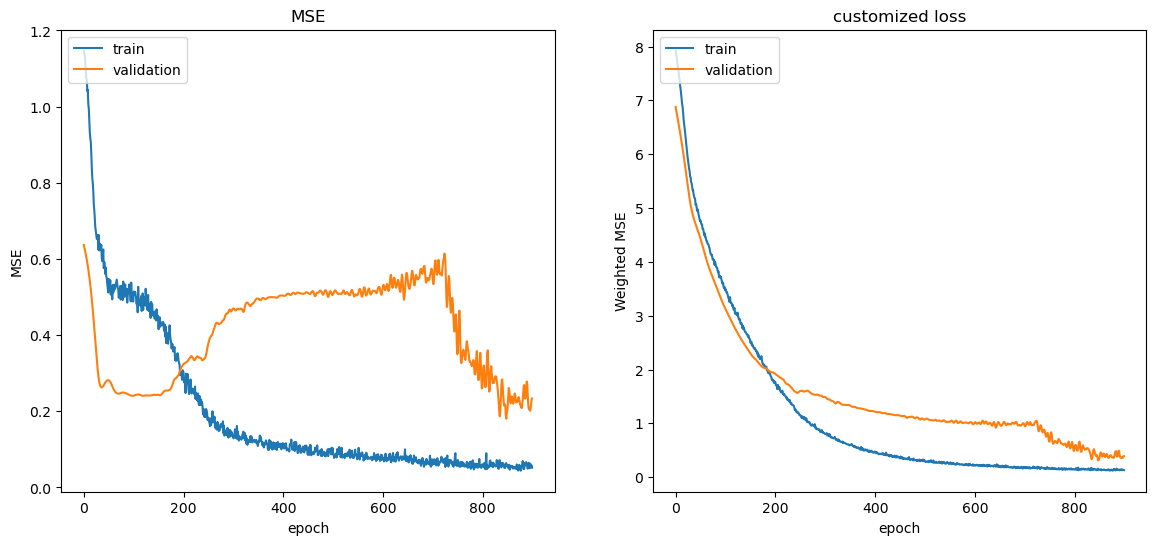

In [49]:
#plot the mse of the training and validation on the left(2,1) and the loss of the training and validation on the right(2,2)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(CNN_attention_history.history['mean_squared_error'][:])
plt.plot(CNN_attention_history.history['val_mean_squared_error'][:])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(CNN_attention_history.history['loss'][:])
plt.plot(CNN_attention_history.history['val_loss'][:])
plt.title('customized loss')
plt.ylabel('Weighted MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [69]:
#set a timer to record the time of the prediction]
import time
start = time.time()
# predict the data_testing_X
y_pred = CNN_attention_model.predict(data_testing_X)

end = time.time()
print("Time taken to predict the data_testing_X is ", end - start)
# Rounding the predictions
rounded_predictions = round_to_nearest_half(y_pred)

Time taken to predict the data_testing_X is  0.11441993713378906


In [70]:
# calculate the mse of prediction

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# calculate the mse of the prediction
mse = mean_squared_error(data_testing_Y, y_pred)

mse

0.608123877984092

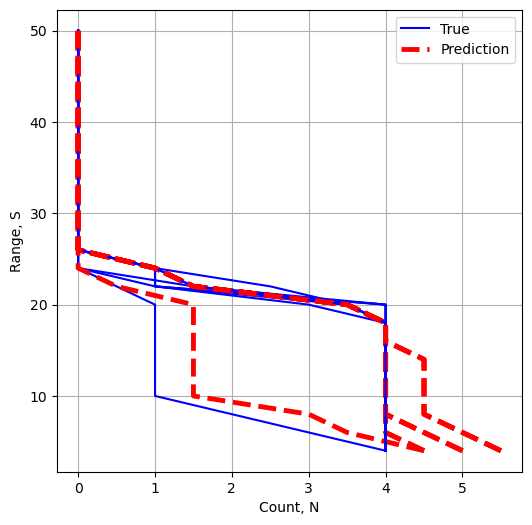

In [71]:
S = list(range(4,52,2))

# Plot all predictions on a same plot
figure = plt.figure(figsize=(6, 6))
for i in range(len(rounded_predictions)):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    #plt.semilogx(Ncum, S, color = 'blue')
    plt.plot(Ncum, S, color = 'blue',linewidth=1.5, label='True')
    #plt.semilogx(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5)
    plt.plot(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5, label='Prediction')
    #plt.title('train number = '+str(test_num[i]))
    # plot the one sigma error bar
    #plt.fill_betweenx(S, pre_Ncum - one_sigma, pre_Ncum + one_sigma, color='red', alpha=0.05)
    plt.xlabel('Count, N')
    plt.ylabel('Range, S')
    #plt.legend()
    plt.grid(True)
    if i == 0:
        plt.legend()

# add a test to the plot to show the color of the line

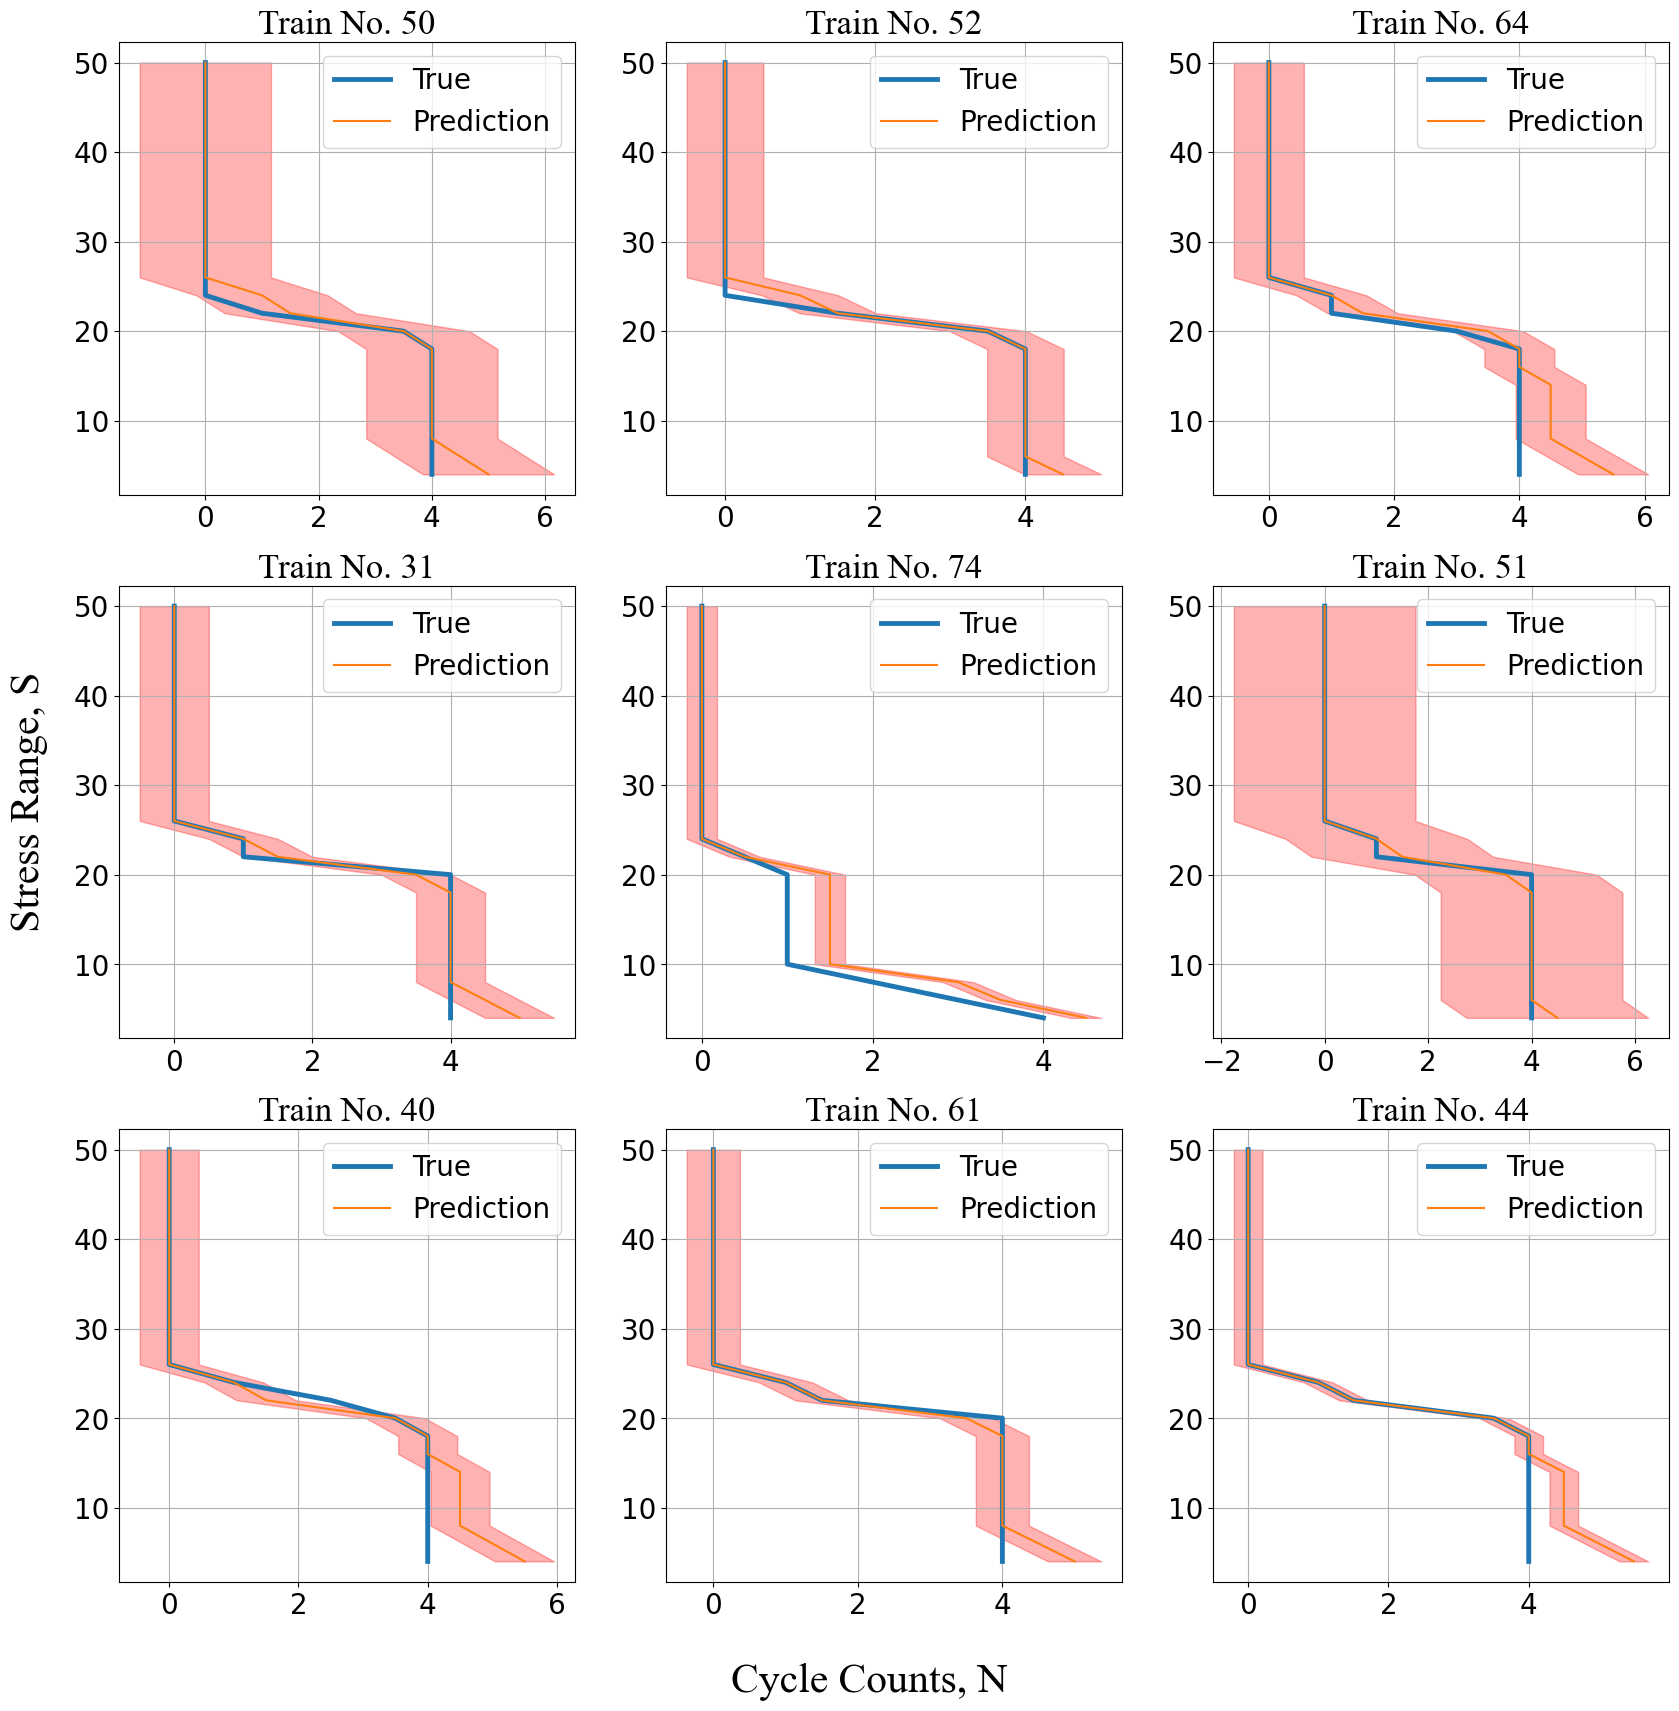

In [72]:


# Assuming 'rounded_predictions', 'data_testing_Y', and 'test_num' are defined
S = list(range(4, 52, 2))
figure, axes = plt.subplots(3, 3, figsize=(20, 20))

# Adjust the spacing to reduce space between subplots
# Lower values of hspace and wspace will reduce the space between subplots
figure.subplots_adjust(hspace=0.2, wspace=0.2)  # adjust these values as needed

for i in range(len(rounded_predictions)):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    ax = axes[i // 3, i % 3]
    ax.plot(Ncum, S, label='True', linewidth=3.5)
    ax.fill_betweenx(S, pre_Ncum - one_sigma, pre_Ncum + one_sigma, color='red', alpha=0.3)
    ax.plot(pre_Ncum, S, label='Prediction',linewidth=1.5)
    ax.set_title('Train No. ' + str(test_num[i]), fontsize=25, fontdict={'family': 'Times New Roman'})
    
    # Setting tick label sizes
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    
    ax.grid(True)
    ax.legend(fontsize=20)

# Set common labels
figure.text(0.5, 0.06, 'Cycle Counts, N', ha='center', va='center', fontsize=30, fontdict={'family': 'Times New Roman'})
figure.text(0.08, 0.5, 'Stress Range, S', ha='center', va='center', rotation='vertical', fontsize=30, fontdict={'family': 'Times New Roman'})

plt.show()


In [66]:
from tensorflow.keras.models import load_model
# LOAD THE TRAINED MODEL
# Load the model
from tensorflow.keras.models import model_from_json

with open('CNN_attention_model2024-12-10.json', 'r') as f:
    json_string = f.read()

CNN_attention_model = model_from_json(json_string)


# Load the weights into the model
CNN_attention_model.load_weights('CNN_attention_model_weights2024-12-10.h5')

In [67]:
# Compile the model (necessary if you need to train or evaluate the model)
CNN_attention_model.compile(optimizer='Adam', loss=custom_loss, metrics=['mean_squared_error'])

In [68]:
CNN_attention_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 4000, 3)]    0           []                               
                                                                                                  
 batch_normalization_36 (BatchN  (None, 4000, 3)     12          ['input_13[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation_36 (Activation)     (None, 4000, 3)      0           ['batch_normalization_36[0][0]'] 
                                                                                                  
 conv1d_72 (Conv1D)             (None, 1334, 3)      84          ['activation_36[0][0]']   

## visulized the intermdiua output

In [54]:
test_num[4]

74

In [55]:
train_to_visualize = 74
test_num_visualize = 4

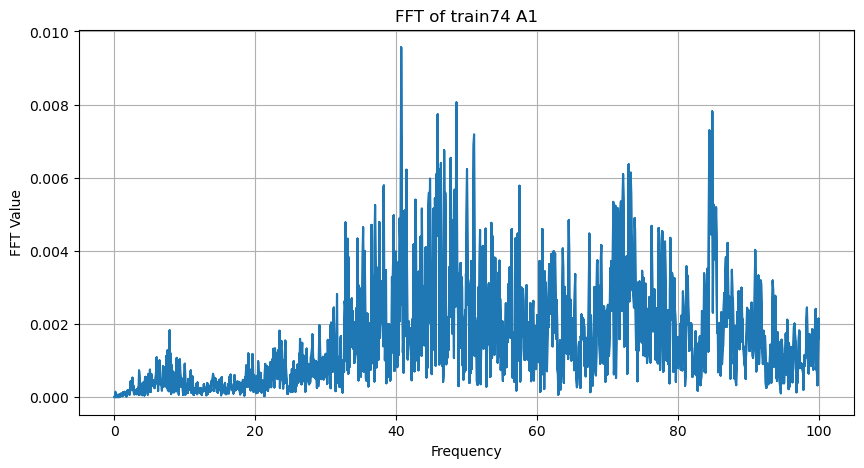

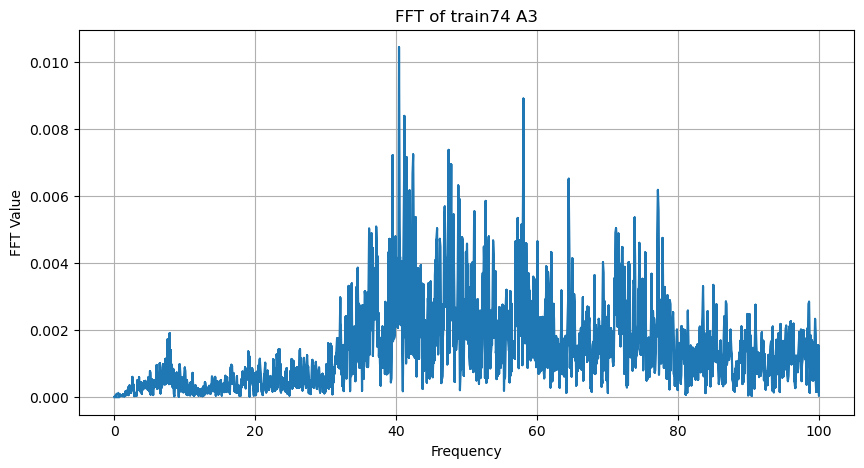

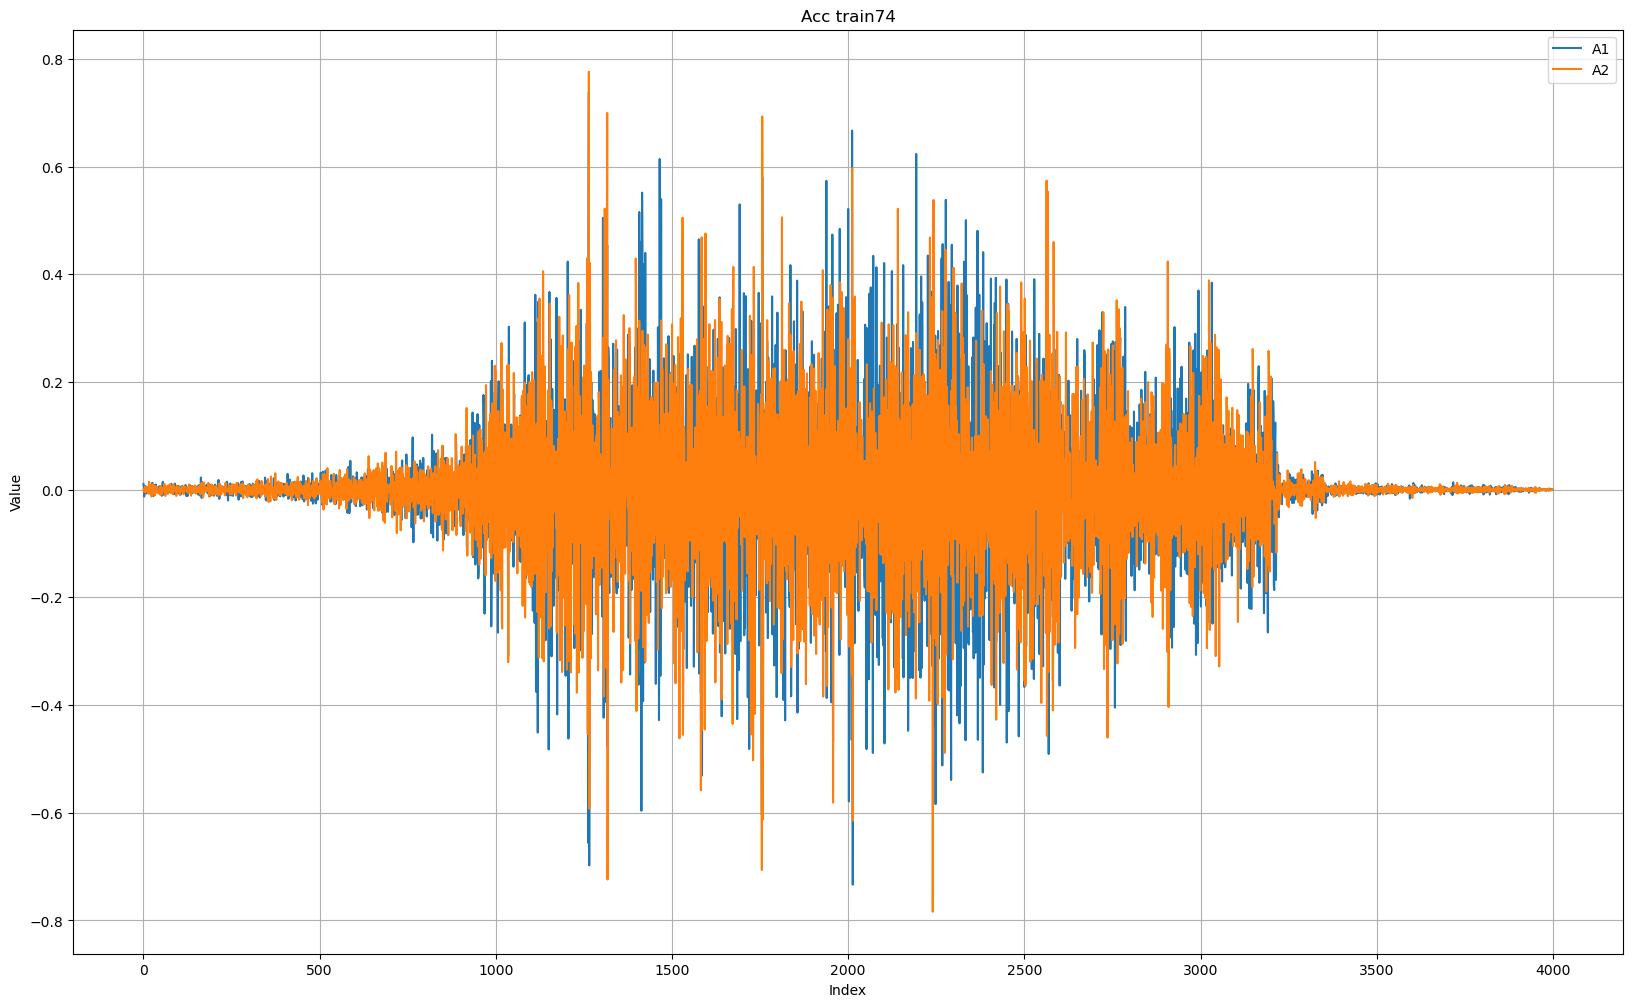

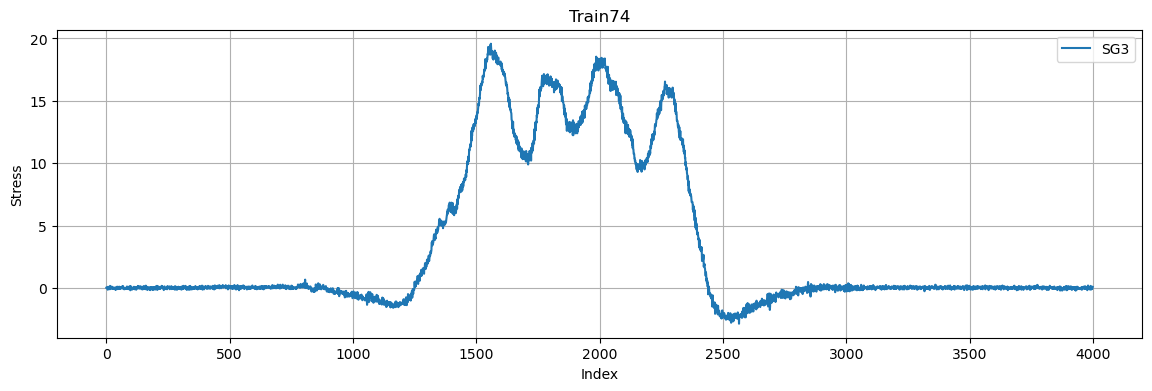

In [56]:
plot_fft(data_testing[train_to_visualize].iloc[:,0],title = "train"+ str(train_to_visualize)+ ' A1')
plot_fft(data_testing[train_to_visualize].iloc[:,1],title = "train"+ str(train_to_visualize) + ' A3')

plt.figure(figsize=(20, 12))
for i in range(0,2,1):
    plt.plot(data_testing[train_to_visualize].iloc[:,i],label=data_testing[train_to_visualize].columns[i])
    plt.legend()
    plt.title('Acc '+str("train"+ str(train_to_visualize)))
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)


plt.figure(figsize=(14, 4))

#plt.plot(data_testing[24]['SG3'][0:],label='SG2')
plt.plot(data_testing[train_to_visualize]['SG3'][0:],label='SG3')
plt.legend()
plt.title('Train'+str(train_to_visualize))
plt.xlabel('Index')
plt.ylabel('Stress')
plt.grid(True)
# save the figure to the file
#plt.savefig('Stress history of Train 0', dpi=500)

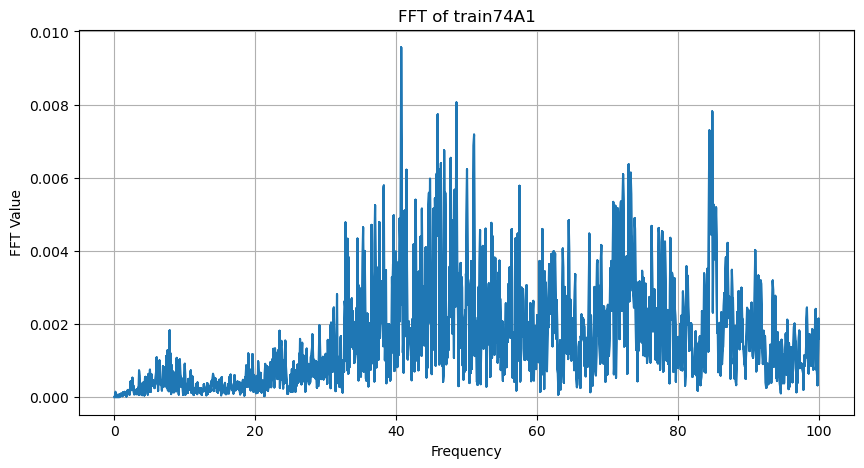

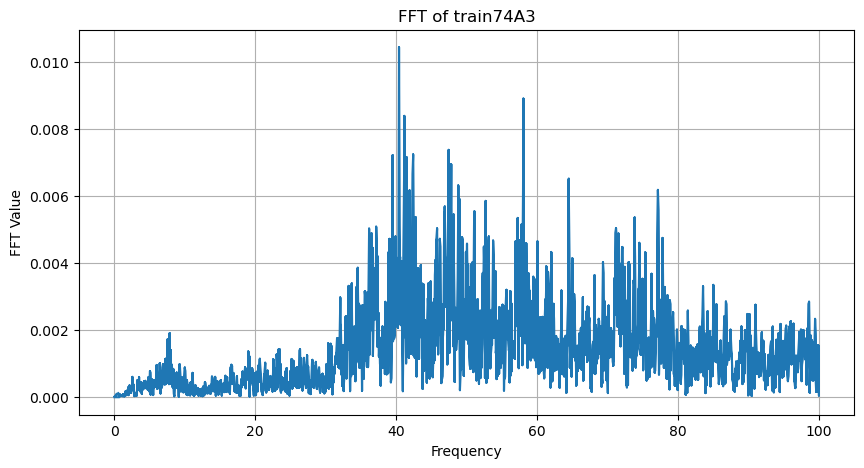

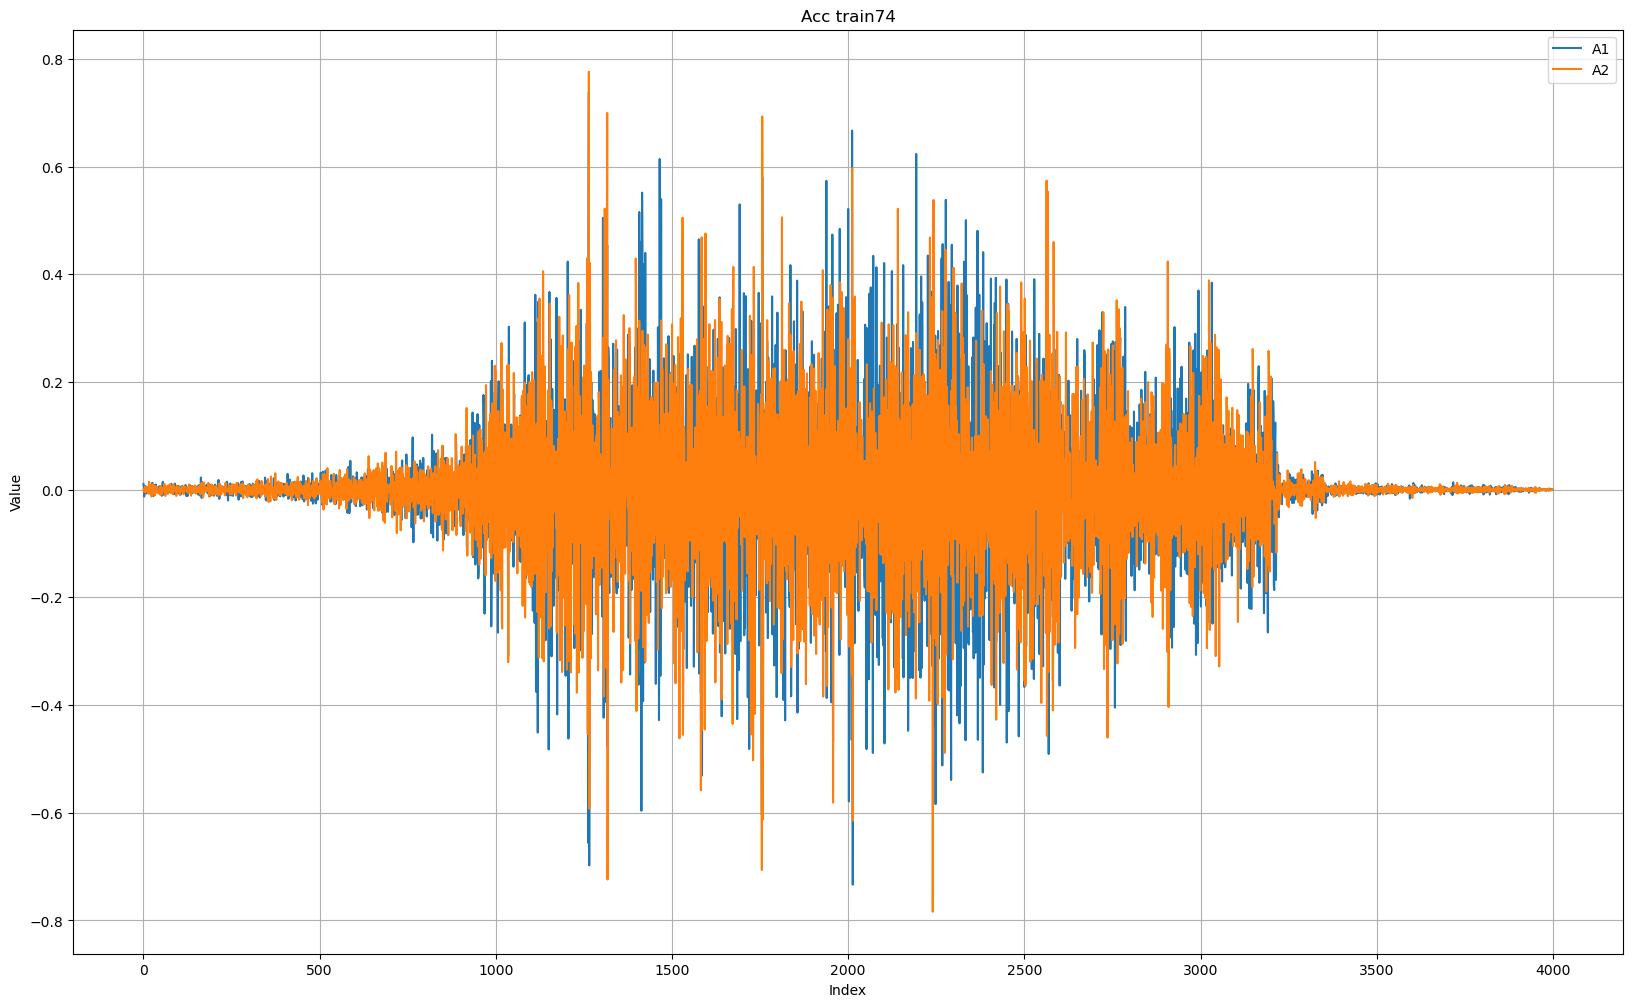

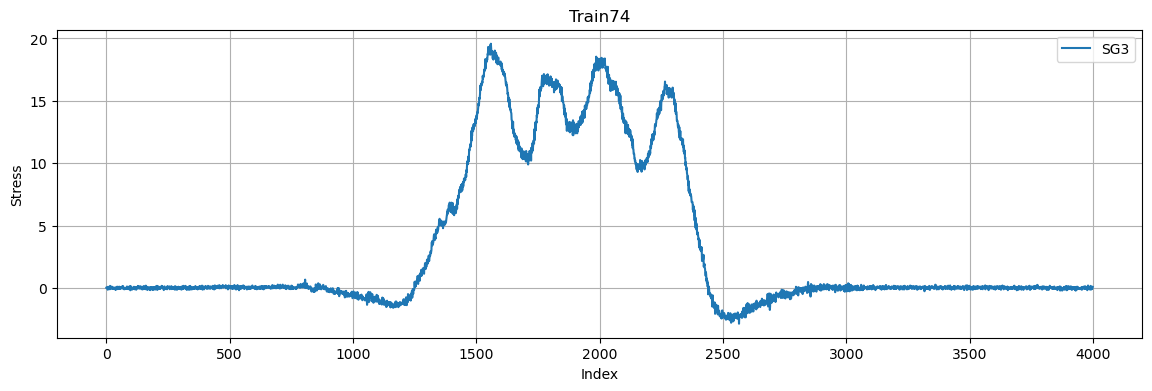

In [57]:
plot_fft(data_testing[train_to_visualize].iloc[:,0],title = "train"+ str(train_to_visualize)+ 'A1')
plot_fft(data_testing[train_to_visualize].iloc[:,1],title = "train"+ str(train_to_visualize) + 'A3')

plt.figure(figsize=(20, 12))
for i in range(0,2,1):
    plt.plot(data_testing[train_to_visualize].iloc[:,i],label=data_testing[train_to_visualize].columns[i])
    plt.legend()
    plt.title('Acc '+str("train"+ str(train_to_visualize)))
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)


plt.figure(figsize=(14, 4))

#plt.plot(data_testing[24]['SG3'][0:],label='SG2')
plt.plot(data_testing[train_to_visualize]['SG3'][0:],label='SG3')
plt.legend()
plt.title('Train'+str(train_to_visualize))
plt.xlabel('Index')
plt.ylabel('Stress')
plt.grid(True)
# save the figure to the file
#plt.savefig('Stress history of Train 0', dpi=500)

In [58]:
from tensorflow.keras.models import Model

# Existing model inputs and outputs
inputs = CNN_attention_model.input

# Desired layers to visualize
#layer_outputs = [layer.output for layer in model.layers if isinstance(layer, (tf.keras.layers.Conv1D, tf.keras.layers.MaxPooling1D))]
layer_outputs = [layer.output for layer in CNN_attention_model.layers if isinstance(layer, (tf.keras.layers.MaxPooling1D))]

# Create a model for visualization

visualization_model = Model(inputs=CNN_attention_model.inputs, outputs=[layer_outputs, attention_scores])


# Select a single sample from each and add a batch dimension
test_input_data = np.expand_dims(data_testing_X[test_num_visualize], axis=0)

print(test_input_data[0].shape)  # Should show (1, length_of_sequence, num_features)
#print(test_input_data[1].shape)  # Should show (1, number_of_scalar_features)


# Make predictions and retrieve attention scores
intermediate_outputs, attention = visualization_model.predict(test_input_data)


(4000, 3)


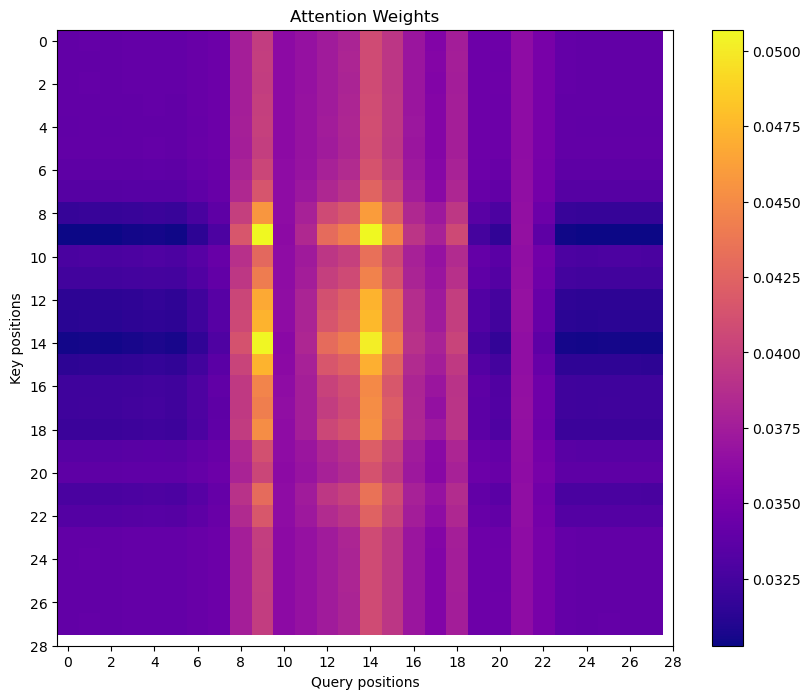

In [59]:
# Attention weights visualization, assuming first example and first attention head

# average attention[0, 0],attention[0, 1],attention[0, 2] and get the mean value

attention_weights = (attention[0, 0] + attention[0, 1] )/2
#attention_weights = attention[0, 0]

plt.figure(figsize=(10, 8))
## Display each attention weights as an image
plt.imshow(attention_weights, cmap='plasma', interpolation='nearest')
plt.colorbar()


plt.title('Attention Weights')
plt.xlabel('Query positions')
plt.ylabel('Key positions')
# make the x with more ticks

plt.xticks(range(0, 30, 2))
plt.yticks(range(0, 30, 2))
plt.show()

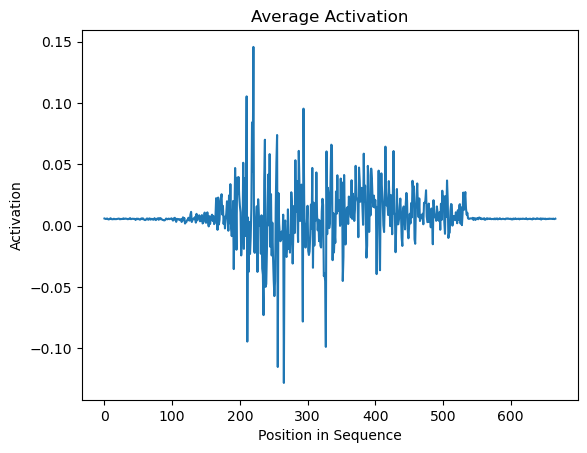

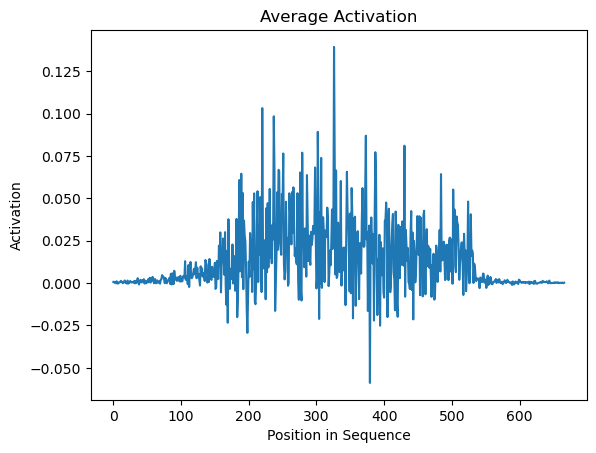

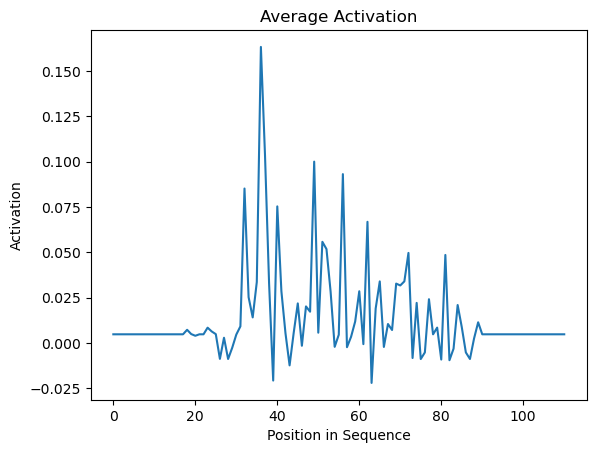

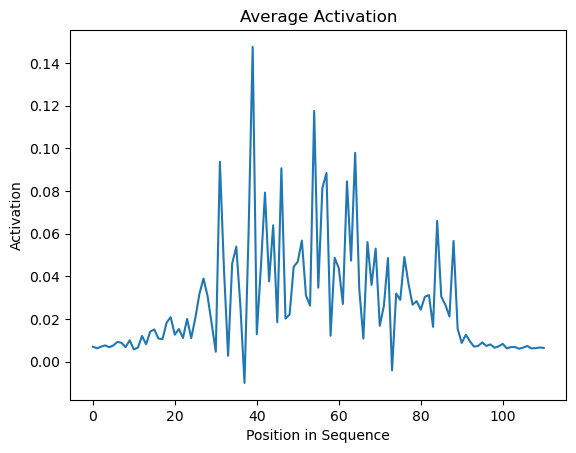

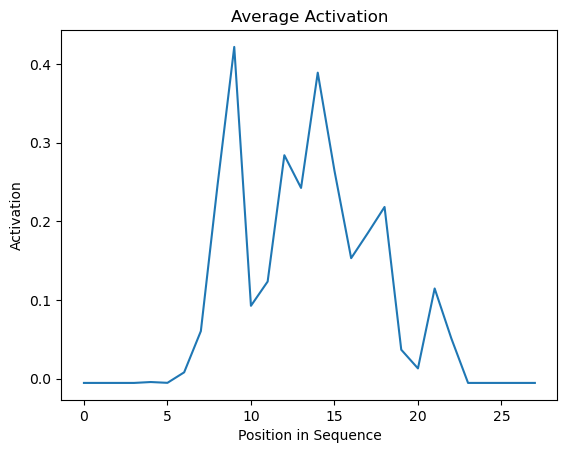

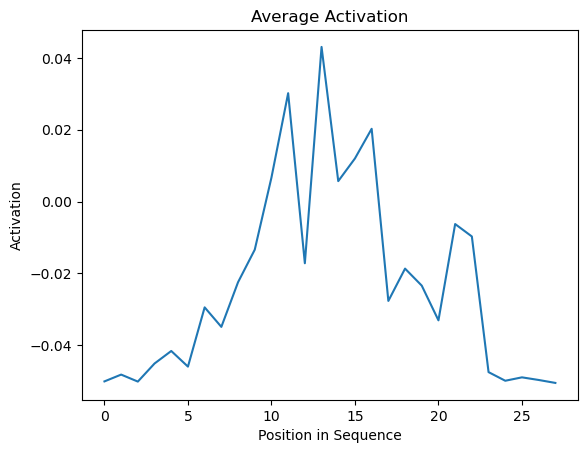

In [60]:
# Plot average activations across filters
for layer_activations in intermediate_outputs:
    avg_activation = np.mean(layer_activations[0], axis=-1)
    plt.plot(avg_activation)
    plt.title('Average Activation')
    plt.ylabel('Activation')
    plt.xlabel('Position in Sequence')
    plt.show()

In [61]:
layer_outputs = []
for layer in CNN_attention_model.layers:
    if isinstance(layer, (tf.keras.layers.Conv1D, tf.keras.layers.MaxPooling1D)):
        layer_outputs.append(layer.output)
        print(f"Layer: {layer.name}, Output Shape: {layer.output_shape}")

Layer: conv1d_10, Output Shape: (None, 1334, 3)
Layer: conv1d_11, Output Shape: (None, 1334, 3)
Layer: max_pooling1d_10, Output Shape: (None, 667, 3)
Layer: max_pooling1d_11, Output Shape: (None, 667, 3)
Layer: conv1d_12, Output Shape: (None, 223, 3)
Layer: conv1d_13, Output Shape: (None, 223, 3)
Layer: max_pooling1d_12, Output Shape: (None, 111, 3)
Layer: max_pooling1d_13, Output Shape: (None, 111, 3)
Layer: conv1d_14, Output Shape: (None, 56, 3)
Layer: conv1d_15, Output Shape: (None, 56, 3)
Layer: max_pooling1d_14, Output Shape: (None, 28, 3)
Layer: max_pooling1d_15, Output Shape: (None, 28, 3)


In [62]:
data_testing_X.shape

(9, 4000, 3)

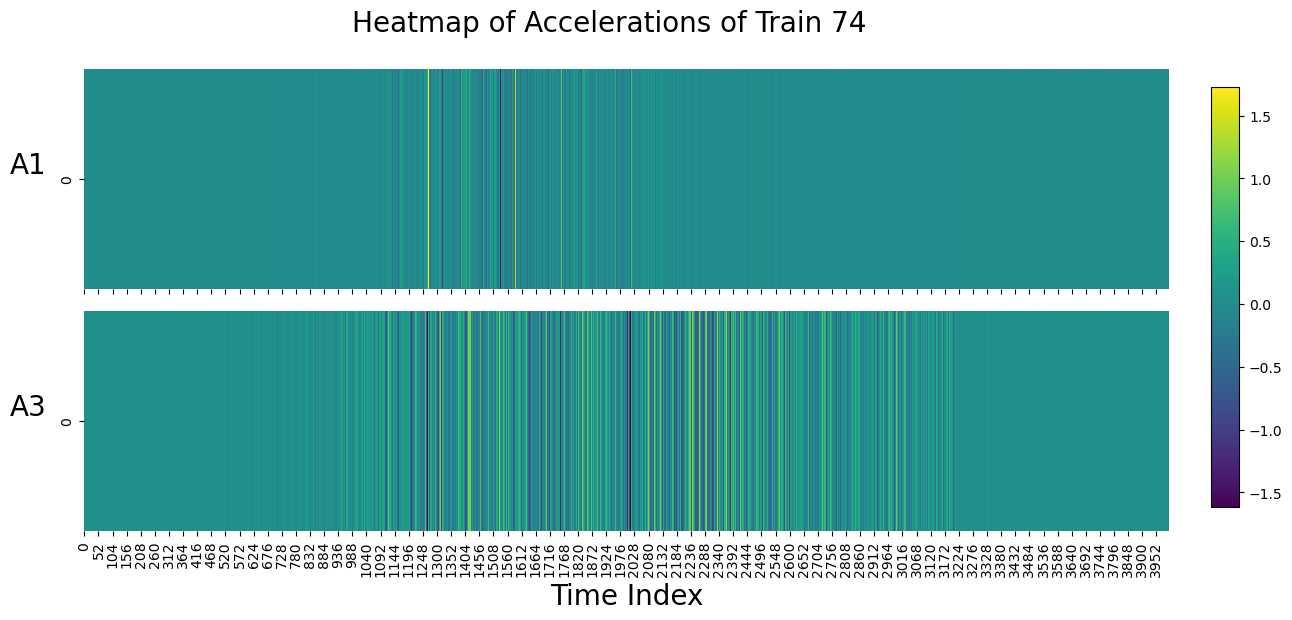

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a single figure with multiple subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 6), sharex=True)

# Plot data for each feature
titles = ['A1', 'A3']
for i, ax in enumerate(axes):
    data = data_testing_X[test_num_visualize][:,i].reshape(1, -1)
    sns_map = sns.heatmap(data, cmap= 'viridis', cbar=False, ax=ax)
    ax.set_ylabel(titles[i], rotation=0, labelpad=10, ha='right',fontsize = 20)  # Horizontal label

# Set xlabel on the last subplot
axes[-1].set_xlabel('Time Index',fontsize=20)

# Create a colorbar axis
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # x, y, width, height (in figure coordinate)

# Normalize the color range based on the data
norm = plt.Normalize(vmin=np.min(data_testing_X[test_num_visualize]), vmax=np.max(data_testing_X[test_num_visualize]))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Create a color bar
fig.colorbar(sm, cax=cbar_ax)

# Adjust layout to make room for colorbar and reduce spacing between plots
plt.subplots_adjust(right=0.9, hspace=0.1)  # hspace controls the vertical gaps between subplots
# set the title of the figure into heatmap of accerlaton data of train 3
plt.suptitle('Heatmap of Accelerations of Train '+ str(train_to_visualize), fontsize=20)

# Save the figure
#plt.savefig('Heatmap of Accelerations of Train 0', dpi=500)

plt.show()


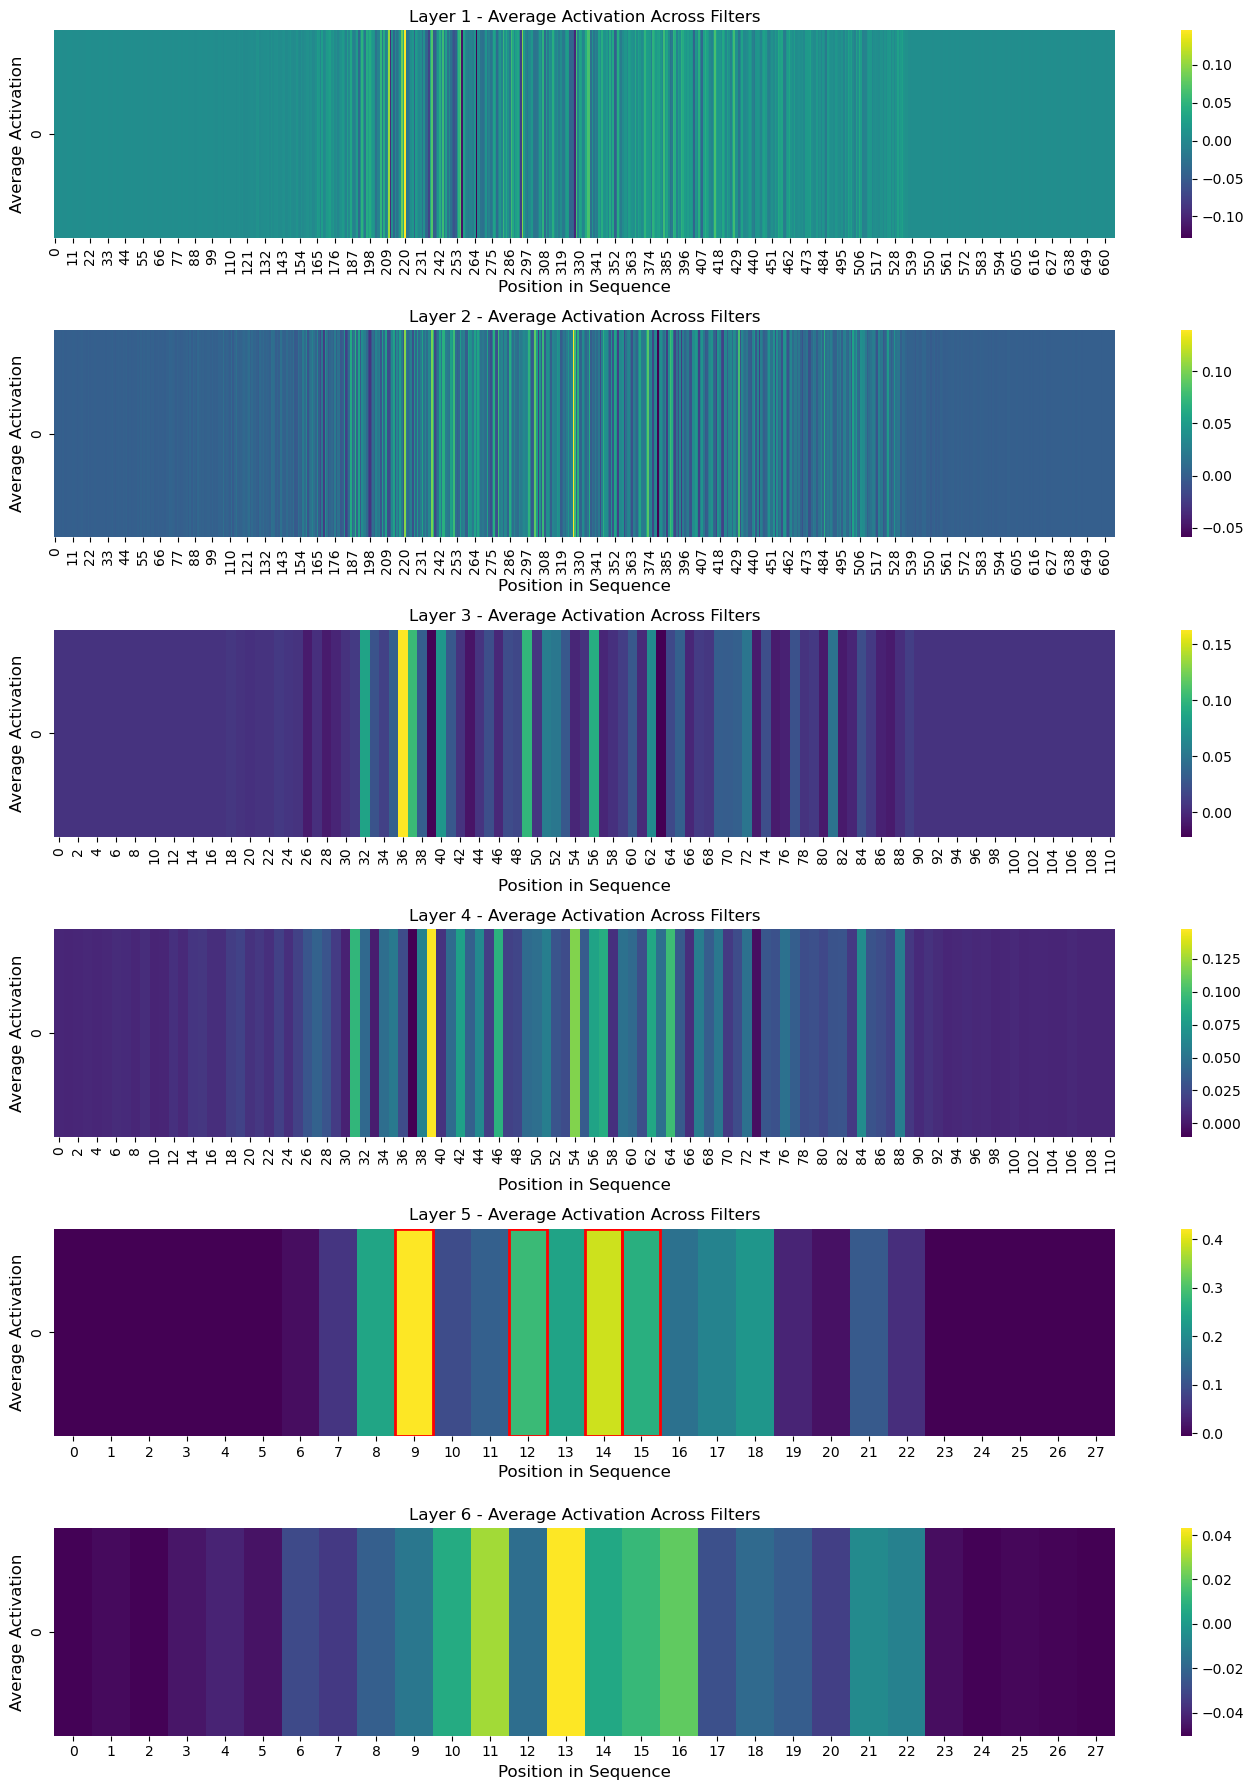

In [64]:

import matplotlib.patches as patches

# Number of layers
num_layers = len(intermediate_outputs)

# Create a single figure with subplots
fig, axes = plt.subplots(nrows=num_layers, figsize=(14, 3 * num_layers))

# Check if there is only one layer to handle indexing appropriately
if num_layers == 1:
    axes = [axes]

for i, layer_activations in enumerate(intermediate_outputs):
    # Calculate the mean across all filters for each feature along the sequence
    avg_activation = np.mean(layer_activations[0], axis=-1)
    
    # Find indices of the top 4 activations
    top_indices = np.argsort(avg_activation)[-4:]  # This gives us the indices of the top 4 values
    
    # Reshape for heatmap (necessary for single dimensional output)
    avg_activation = avg_activation.reshape(1, -1)
    
    # Create heatmap on the appropriate subplot axis
    ax = sns.heatmap(avg_activation, cmap='viridis', cbar=True, ax=axes[i])
    ax.set_title(f'Layer {i+1} - Average Activation Across Filters', fontsize=12)
    ax.set_ylabel('Average Activation', fontsize=12)
    ax.set_xlabel('Position in Sequence', fontsize=12)

    if i == 4:
            # Adding red borders to the top values
        for top_index in top_indices:
            # Add a rectangle patch with red border to the heatmap
            rect = patches.Rectangle((top_index, 0), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)



# Adjust layout
plt.tight_layout()

# Save the figure to the file
# plt.savefig('Average Activation Across Filters 5-1', dpi=500)

plt.show()


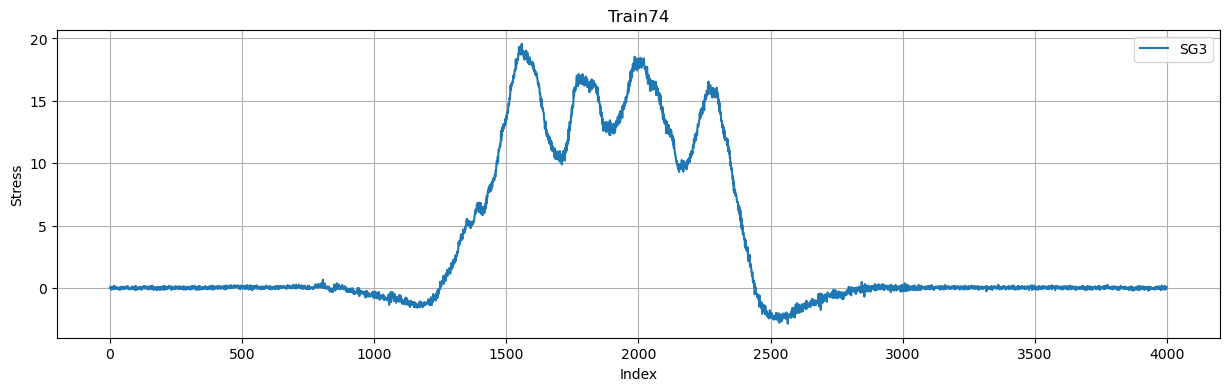

In [65]:
plt.figure(figsize=(15, 4))
plt.plot(data_testing[train_to_visualize]['SG3'],label='SG3')
plt.legend()
plt.title('Train'+str(train_to_visualize))
plt.xlabel('Index')
plt.ylabel('Stress')
plt.grid(True)